In [1]:
# импортируем необходимые библиотеки, 
# модули, классы и функции
import pandas as pd
import numpy as np
import optuna
import random
from functools import partial

# импортируем из библиотеки etna нужные классы
from etna.datasets import TSDataset
from etna.loggers import WandbLogger, tslogger
from etna.metrics import SMAPE
from etna.models import CatBoostMultiSegmentModel
from etna.pipeline import Pipeline
from etna.transforms import (LagTransform,
                             LogTransform,
                             MeanTransform,
                             DateFlagsTransform,
                             LinearTrendTransform,
                             SegmentEncoderTransform,
                             StandardScalerTransform)

# импортируем функцию plot_forecast()
# для визуализации прогнозов
from etna.analysis import plot_forecast

# увеличиваем максимальное количество отображаемых столбцов
pd.set_option('display.max_columns', 250)

# импортируем модуль предупреждений
import warnings
# включим игнорирование предупреждений
warnings.filterwarnings('ignore')

from IPython.display import display
from IPython.core.display import HTML

/Users/artemgruzdev/anaconda3/lib/python3.10/site-packages/etna/settings.py:61: UserWarning: `tsfresh` is not available, to install it, run `pip install tsfresh==0.19.0 && pip install protobuf==3.20.1`
  warnings.warn(


In [2]:
# функция установки начального значения 
# генератора псевдослучайных чисел
def set_seed(seed=42):
    # установка генератора случайных чисел Python 
    random.seed(seed)
    # установка генератора случайных чисел NumPy
    np.random.seed(seed)

In [3]:
# функция логгирования
def init_logger(config, 
                project='wandb-sweeps', 
                tags=['test', 'sweeps']):
    # создание пустого списка для хранения обьектов WandbLogger
    tslogger.loggers = []
    # создание экземпляра WandbLogger, W&B предоставляет 
    # облегченную оболочку для регистрации экспериментов 
    # машинного обучения
    wblogger = WandbLogger(project=project, tags=tags, config=config)
    # добавление объекта WandbLogger в список
    tslogger.add(wblogger)

## Оптимизация гиперпараметров с выделением отдельной тестовой выборки

In [4]:
# целевая функция Optuna
def objective(trial, ts, horizon, metrics, metric_name, n_folds, depth, 
              lag_upper_bound, lag_step, window_size,
              print_configurations, print_metrics, seed):

    # установка начального значения генератора случайных чисел 
    set_seed(seed)
    
    # создаем экземпляр класса LogTransform для логарифмирования 
    # зависимой переменной
    log = LogTransform(in_column='target')
    
    # создаем экземпляр класса StandardScalerTransform
    # для стандартизации зависимой переменной
    scaler = StandardScalerTransform('target')
    
    # создаем экземпляр класса LinearTrendTransform для прогнозирования 
    # тренда, удаления тренда из даннных и добавления тренда к прогнозам
    detrend = LinearTrendTransform(in_column='target')

    # создаем экземпляр класса SegmentEncoderTransform для 
    # кодирования меток сегментов целочисленными значениями 
    # в лексикографическом порядке (LabelEncoding): сегменты
    # a, b, c, d получат значения 0, 1, 2, 3
    seg = SegmentEncoderTransform()
    
    # создаем экземпляр класса LagTransform для генерации лагов
    lag = LagTransform(
        in_column='target', 
        lags=list(
            range(horizon, 
                  trial.suggest_int('lag_upper_bound', 100, lag_upper_bound), 
                  trial.suggest_int('lag_step', 5, lag_step)
                 )
        )
    )
    
    # создаем экземпляр класса MeanTransform 
    # для генерации скользящих средних
    mean = MeanTransform(
        in_column='target', 
        window=trial.suggest_int('window_size', horizon, window_size)
    )
       
    # создаем экземпляр класса DateFlagsTransform
    # для генерации признаков на основе дат
    d_flags = DateFlagsTransform(day_number_in_week=True,
                                 day_number_in_month=True,
                                 month_number_in_year=True,
                                 season_number=True,
                                 is_weekend=True, 
                                 out_column='datetime')
    
    transforms = [log, scaler, detrend, seg, lag, mean, d_flags]
    
    #  создадим экземпляр Pipeline
    pipeline = Pipeline(
        # определим модель
        model = CatBoostMultiSegmentModel(
            iterations=500,
            depth=trial.suggest_int('depth', 3, depth)
        ),
        # определим список трансформеров
        transforms=transforms,
        # установка горизонта для прогнозов
        horizon=horizon
    )
    
    # печатаем конфигурацию гиперпараметров
    if print_configurations:
        print(f'\nконфигурация:\n{pipeline}')
        
    # инициализируем WandB logger
    init_logger(pipeline.to_dict())

    # запускаем перекрестную проверку с подсчетом метрик
    df_metrics, _, _ = pipeline.backtest(ts=ts, metrics=[metrics], 
                                         n_folds=n_folds,
                                         aggregate_metrics=True)
    
    # печатаем метрики
    if print_metrics:
        print(f'метрика по сегментам:\n{df_metrics}')
    
    # возвращаем средние значения по найденным метрикам
    return df_metrics[metric_name].mean()

In [5]:
#функции, корректно выводящие pandas-датафрейм
def bugfixed_display(df):
        display(HTML("<style scoped>.bugfix {display: flex; flex-grow: 0;}</style><div class='bugfix'>" + 
        df[:5].to_html()
        + "</div>"))
        print('...')
        display(HTML("<style scoped>.bugfix {display: flex; flex-grow: 0;}</style><div class='bugfix'>" + 
        df[-5:].to_html()
        + "</div>"))

def bugfixed_full_display(df):
    display(HTML("<style scoped>.bugfix {display: flex; flex-grow: 0;}</style><div class='bugfix'>" + 
    df.to_html()
    + "</div>"))

In [6]:
# функция, создающая обучающий и тестовый наборы
def train_test_dataloader(internal_hist_path,
                          external_hist_path,
                          horizon=90,
                          freq='D',
                          verbose=False):
    
    # загружаем исторические данные о продажах
    hist_sales = pd.read_csv(internal_hist_path, 
                             index_col=['date'], 
                             parse_dates=['date'])
    
    if verbose:
        print('загружаем исторические данные о продажах')
        bugfixed_display(hist_sales)
    
    # загружаем исторические данные о рекламной активности
    hist_advert = pd.read_csv(external_hist_path, 
                              parse_dates=['date'])
    
    if verbose:
        print('загружаем исторические данные о рекламной активности')
        bugfixed_display(hist_advert)
        
    # заполним пропуски в исторических рядах продаж
    # с помощью линейной интерполяции
    for col in hist_sales.columns.tolist():
        hist_sales[col] = hist_sales[col].interpolate(method='linear')
        
    if verbose:
        print('заполним пропуски в исторических данных о продажах ' 
              'с помощью линейной интерполяции')
        bugfixed_display(hist_sales)
        
    # формируем обучающий набор продаж
    train_sales = hist_sales.iloc[:-horizon]
    
    if verbose:
        print('формируем обучающий набор продаж')
        bugfixed_display(train_sales)
        
    # отбираем наблюдения с 2013 года и сбрасываем прежний индекс
    # в исторических данных о рекламной активности
    train_sales = train_sales[train_sales.index >= '2013-01-01']
    hist_advert = hist_advert[hist_advert['date'] >= '2013-01-01'].reset_index(
        drop=True)
    
    if verbose:
        print('отбираем наблюдения с 2013 года и сбрасываем прежний \n'
              'индекс в исторических данных о рекламной активности')
        bugfixed_display(train_sales)
        bugfixed_display(hist_advert)
        
    # выделим столбец с датой в обучающем наборе продаж
    train_sales['timestamp'] = train_sales.index
    # сбрасываем прежний индекс
    train_sales = train_sales.reset_index(drop=True)
    
    if verbose:
        print('выделим столбец с датой в обучающем наборе продаж '
              'и сбросим прежний индекс')
        bugfixed_display(train_sales)
           
    # расплавляем обучающий набор продаж в длинный датафрейм
    train_sales_melt = train_sales.melt(id_vars='timestamp', 
                                        var_name='segment', 
                                        value_name='target')
    
    if verbose:
        print('расплавляем обучающий набор продаж в длинный датафрейм')
        bugfixed_display(train_sales_melt)
        
    # переводим обучающий набор продаж в формат ETNA
    train_ts_format = TSDataset.to_dataset(train_sales_melt)    
    
    if verbose:
        print('переводим обучающий набор продаж в формат ETNA')
        bugfixed_display(train_ts_format)
        
    # переименовываем date в timestamp в исторических 
    # данных о рекламной активности
    hist_advert.rename(columns={'date': 'timestamp'}, inplace=True)
    # расплавляем исторические данные о рекламной 
    # активности в длинный датафрейм
    hist_advert_melt = hist_advert.melt(id_vars='timestamp', 
                                        var_name='segment', 
                                        value_name='advert')
    
    if verbose:
        print('переименовываем date в timestamp в исторических данных '
              'о рекламной активности и расплавляем в длинный датафрейм')
        bugfixed_display(hist_advert_melt)
    
    # создаем переменную - квартал
    hist_advert_melt['quarter'] = hist_advert_melt[
        'timestamp'
    ].dt.quarter
    # создаем переменную - начало квартала
    hist_advert_melt['quarter_start'] = hist_advert_melt[
        'timestamp'
    ].dt.is_quarter_start
    # создаем переменную - конец квартала
    hist_advert_melt['quarter_end'] = hist_advert_melt[
        'timestamp'
    ].dt.is_quarter_end
    # создаем переменную - название месяца
    hist_advert_melt['month_name'] = hist_advert_melt[
        'timestamp'
    ].dt.strftime('%b')
    hist_advert_melt['month_name'] = hist_advert_melt[
        'month_name'
    ].astype('category')
    
    if verbose:
        print('создаем календарные признаки в исторических данных '
              'о рекламной активности')
        bugfixed_display(hist_advert_melt)
    
    # переводим набор с экзогенными переменными (рекламная активность,
    # календарные признаки) в формат ETNA
    hist_regressors_ts_format = TSDataset.to_dataset(hist_advert_melt)
    
    if verbose:
        print('переводим набор с экзогенными переменными (рекламная '
              'активность, календарные признаки) в формат ETNA')
        display(hist_regressors_ts_format)
    
    # создаем итоговый обучающий набор как объект TSDataset
    train_ts = TSDataset(
        train_ts_format, freq=freq, 
        df_exog=hist_regressors_ts_format, known_future='all')
    
    if verbose:
        print('создаем итоговый обучающий набор как объект TSDataset')
        display(train_ts)
        
    # формируем тестовый набор продаж
    test_sales = hist_sales.iloc[-horizon:]
    
    if verbose:
        print('формируем тестовый набор продаж')
        bugfixed_display(test_sales)
        
    # выделим столбец с датой
    test_sales['timestamp'] = test_sales.index
    # сбрасываем прежний индекс
    test_sales = test_sales.reset_index(drop=True)
    
    if verbose:
        print('выделим столбец с датой в тестовом наборе продаж '
              'и сбросим прежний индекс')
        bugfixed_display(test_sales)
        
    # расплавляем тестовый набор продаж в длинный датафрейм
    test_sales_melt = test_sales.melt(id_vars='timestamp', 
                                      var_name='segment', 
                                      value_name='target')
    
    if verbose:
        print('расплавляем тестовый набор продаж в длинный датафрейм')
        bugfixed_display(test_sales_melt)
        
    # переводим тестовый набор продаж в формат ETNA
    test_ts_format = TSDataset.to_dataset(test_sales_melt)
    
    # превращаем тестовый набор продаж в объект TSDataset, 
    # задав частоту временного ряда
    test_ts = TSDataset(test_ts_format, freq=freq)
    
    if verbose:
        print('превращаем тестовый набор продаж в объект TSDataset')
        bugfixed_display(test_ts.df)
    
    return train_ts, test_ts

In [7]:
# задаем горизонт прогнозирования
HORIZON = 90

# создаем обучающий и тестовый наборы
train_ts, test_ts = train_test_dataloader(
    # путь к историческому набору эндогенных переменных
    internal_hist_path='Data/raif/sales_train.csv', 
    # путь к историческому набору экзогенных переменных
    external_hist_path='Data/raif/advert_train.csv',
    horizon=HORIZON,
    freq='D',
    verbose=True)

загружаем исторические данные о продажах


,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
date,,,,,,,,
2008-01-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2008-01-03,NaN,1.006943,1.002595,1.006953,1.014819,NaN,1.008989,1.003241
2008-01-04,1.015188,NaN,1.043535,1.044507,1.050865,1.025508,1.037337,1.024117
2008-01-05,NaN,1.045076,NaN,1.080214,1.071665,NaN,NaN,1.028124
2008-01-06,0.995762,1.000988,1.051633,1.056388,1.047756,1.002896,1.027538,0.990433


...


,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
date,,,,,,,,
2015-12-27,2.162458,NaN,2.515498,3.871723,4.061596,NaN,3.416342,4.336864
2015-12-28,NaN,3.425255,2.525145,NaN,4.057857,3.835661,3.363259,4.326631
2015-12-29,2.164239,NaN,2.524327,3.883184,4.056121,3.852841,3.330472,4.319235
2015-12-30,2.168029,3.435747,2.538544,3.893227,4.062142,3.855567,3.321401,4.307126
2015-12-31,NaN,3.424718,2.545287,3.887936,4.059624,3.847464,3.308644,4.295573


загружаем исторические данные о рекламной активности


,date,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
0,2008-01-02,0,0,0,0,0,0,0,0
1,2008-01-03,0,0,0,0,0,0,0,0
2,2008-01-04,0,0,0,0,0,0,0,0
3,2008-01-05,0,0,0,0,0,0,0,0
4,2008-01-06,0,0,0,0,0,0,0,0


...


,date,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
2916,2015-12-27,0,0,0,0,0,0,1,0
2917,2015-12-28,0,0,0,0,0,0,0,0
2918,2015-12-29,0,0,0,0,0,0,0,0
2919,2015-12-30,0,0,0,0,0,0,0,0
2920,2015-12-31,0,0,0,0,0,0,0,0


заполним пропуски в исторических данных о продажах с помощью линейной интерполяции


,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
date,,,,,,,,
2008-01-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2008-01-03,1.007594,1.006943,1.002595,1.006953,1.014819,1.012754,1.008989,1.003241
2008-01-04,1.015188,1.026009,1.043535,1.044507,1.050865,1.025508,1.037337,1.024117
2008-01-05,1.005475,1.045076,1.047584,1.080214,1.071665,1.014202,1.032438,1.028124
2008-01-06,0.995762,1.000988,1.051633,1.056388,1.047756,1.002896,1.027538,0.990433


...


,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
date,,,,,,,,
2015-12-27,2.162458,3.457937,2.515498,3.871723,4.061596,3.846346,3.416342,4.336864
2015-12-28,2.163348,3.425255,2.525145,3.877453,4.057857,3.835661,3.363259,4.326631
2015-12-29,2.164239,3.430501,2.524327,3.883184,4.056121,3.852841,3.330472,4.319235
2015-12-30,2.168029,3.435747,2.538544,3.893227,4.062142,3.855567,3.321401,4.307126
2015-12-31,2.168029,3.424718,2.545287,3.887936,4.059624,3.847464,3.308644,4.295573


формируем обучающий набор продаж


,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
date,,,,,,,,
2008-01-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2008-01-03,1.007594,1.006943,1.002595,1.006953,1.014819,1.012754,1.008989,1.003241
2008-01-04,1.015188,1.026009,1.043535,1.044507,1.050865,1.025508,1.037337,1.024117
2008-01-05,1.005475,1.045076,1.047584,1.080214,1.071665,1.014202,1.032438,1.028124
2008-01-06,0.995762,1.000988,1.051633,1.056388,1.047756,1.002896,1.027538,0.990433


...


,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
date,,,,,,,,
2015-09-28,2.723050,3.792996,2.876638,4.006018,4.135877,3.916941,3.354754,4.674669
2015-09-29,2.732791,3.797767,2.901077,4.011578,4.139024,3.856932,3.368017,4.675640
2015-09-30,2.730469,3.799346,2.906778,4.022139,4.132845,3.796923,3.266779,4.674082
2015-10-01,2.528209,3.596155,2.821187,3.806698,3.925870,3.736913,3.165541,4.465773
2015-10-02,2.566138,3.625612,2.735596,3.835433,3.962537,3.758438,3.204902,4.498011


отбираем наблюдения с 2013 года и сбрасываем прежний 
индекс в исторических данных о рекламной активности


,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
date,,,,,,,,
2013-01-01,1.709516,2.318572,1.721826,2.190858,2.163801,2.156222,1.672642,2.697802
2013-01-02,1.717525,2.329281,1.721189,2.195295,2.168168,2.175232,1.685756,2.704513
2013-01-03,1.723990,2.339989,1.719877,2.198767,2.182105,2.186773,1.698870,2.699439
2013-01-04,1.750044,2.350698,1.752980,2.202239,2.196042,2.227879,1.711984,2.695610
2013-01-05,1.731752,2.346491,1.759707,2.186557,2.193507,2.218857,1.701571,2.691781


...


,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
date,,,,,,,,
2015-09-28,2.723050,3.792996,2.876638,4.006018,4.135877,3.916941,3.354754,4.674669
2015-09-29,2.732791,3.797767,2.901077,4.011578,4.139024,3.856932,3.368017,4.675640
2015-09-30,2.730469,3.799346,2.906778,4.022139,4.132845,3.796923,3.266779,4.674082
2015-10-01,2.528209,3.596155,2.821187,3.806698,3.925870,3.736913,3.165541,4.465773
2015-10-02,2.566138,3.625612,2.735596,3.835433,3.962537,3.758438,3.204902,4.498011


,date,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
0,2013-01-01,0,0,0,0,0,0,0,0
1,2013-01-02,0,0,0,0,0,0,0,0
2,2013-01-03,0,0,0,0,0,0,0,0
3,2013-01-04,0,0,0,0,0,0,0,0
4,2013-01-05,0,0,0,0,0,0,0,0


...


,date,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
1090,2015-12-27,0,0,0,0,0,0,1,0
1091,2015-12-28,0,0,0,0,0,0,0,0
1092,2015-12-29,0,0,0,0,0,0,0,0
1093,2015-12-30,0,0,0,0,0,0,0,0
1094,2015-12-31,0,0,0,0,0,0,0,0


выделим столбец с датой в обучающем наборе продаж и сбросим прежний индекс


,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8,timestamp
0,1.709516,2.318572,1.721826,2.190858,2.163801,2.156222,1.672642,2.697802,2013-01-01
1,1.717525,2.329281,1.721189,2.195295,2.168168,2.175232,1.685756,2.704513,2013-01-02
2,1.723990,2.339989,1.719877,2.198767,2.182105,2.186773,1.698870,2.699439,2013-01-03
3,1.750044,2.350698,1.752980,2.202239,2.196042,2.227879,1.711984,2.695610,2013-01-04
4,1.731752,2.346491,1.759707,2.186557,2.193507,2.218857,1.701571,2.691781,2013-01-05


...


,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8,timestamp
1000,2.723050,3.792996,2.876638,4.006018,4.135877,3.916941,3.354754,4.674669,2015-09-28
1001,2.732791,3.797767,2.901077,4.011578,4.139024,3.856932,3.368017,4.675640,2015-09-29
1002,2.730469,3.799346,2.906778,4.022139,4.132845,3.796923,3.266779,4.674082,2015-09-30
1003,2.528209,3.596155,2.821187,3.806698,3.925870,3.736913,3.165541,4.465773,2015-10-01
1004,2.566138,3.625612,2.735596,3.835433,3.962537,3.758438,3.204902,4.498011,2015-10-02


расплавляем обучающий набор продаж в длинный датафрейм


,timestamp,segment,target
0,2013-01-01,market_1,1.709516
1,2013-01-02,market_1,1.717525
2,2013-01-03,market_1,1.723990
3,2013-01-04,market_1,1.750044
4,2013-01-05,market_1,1.731752


...


,timestamp,segment,target
8035,2015-09-28,market_8,4.674669
8036,2015-09-29,market_8,4.675640
8037,2015-09-30,market_8,4.674082
8038,2015-10-01,market_8,4.465773
8039,2015-10-02,market_8,4.498011


переводим обучающий набор продаж в формат ETNA


segment,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
feature,target,target,target,target,target,target,target,target
timestamp,,,,,,,,
2013-01-01,1.709516,2.318572,1.721826,2.190858,2.163801,2.156222,1.672642,2.697802
2013-01-02,1.717525,2.329281,1.721189,2.195295,2.168168,2.175232,1.685756,2.704513
2013-01-03,1.723990,2.339989,1.719877,2.198767,2.182105,2.186773,1.698870,2.699439
2013-01-04,1.750044,2.350698,1.752980,2.202239,2.196042,2.227879,1.711984,2.695610
2013-01-05,1.731752,2.346491,1.759707,2.186557,2.193507,2.218857,1.701571,2.691781


...


segment,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
feature,target,target,target,target,target,target,target,target
timestamp,,,,,,,,
2015-09-28,2.723050,3.792996,2.876638,4.006018,4.135877,3.916941,3.354754,4.674669
2015-09-29,2.732791,3.797767,2.901077,4.011578,4.139024,3.856932,3.368017,4.675640
2015-09-30,2.730469,3.799346,2.906778,4.022139,4.132845,3.796923,3.266779,4.674082
2015-10-01,2.528209,3.596155,2.821187,3.806698,3.925870,3.736913,3.165541,4.465773
2015-10-02,2.566138,3.625612,2.735596,3.835433,3.962537,3.758438,3.204902,4.498011


переименовываем date в timestamp в исторических данных о рекламной активности и расплавляем в длинный датафрейм


,timestamp,segment,advert
0,2013-01-01,market_1,0
1,2013-01-02,market_1,0
2,2013-01-03,market_1,0
3,2013-01-04,market_1,0
4,2013-01-05,market_1,0


...


,timestamp,segment,advert
8755,2015-12-27,market_8,0
8756,2015-12-28,market_8,0
8757,2015-12-29,market_8,0
8758,2015-12-30,market_8,0
8759,2015-12-31,market_8,0


создаем календарные признаки в исторических данных о рекламной активности


,timestamp,segment,advert,quarter,quarter_start,quarter_end,month_name
0,2013-01-01,market_1,0,1,True,False,Jan
1,2013-01-02,market_1,0,1,False,False,Jan
2,2013-01-03,market_1,0,1,False,False,Jan
3,2013-01-04,market_1,0,1,False,False,Jan
4,2013-01-05,market_1,0,1,False,False,Jan


...


,timestamp,segment,advert,quarter,quarter_start,quarter_end,month_name
8755,2015-12-27,market_8,0,4,False,False,Dec
8756,2015-12-28,market_8,0,4,False,False,Dec
8757,2015-12-29,market_8,0,4,False,False,Dec
8758,2015-12-30,market_8,0,4,False,False,Dec
8759,2015-12-31,market_8,0,4,False,True,Dec


переводим набор с экзогенными переменными (рекламная активность, календарные признаки) в формат ETNA


segment    market_1                                              market_2  \
feature      advert month_name quarter quarter_end quarter_start   advert   
timestamp                                                                   
2013-01-01        0        Jan       1       False          True        0   
2013-01-02        0        Jan       1       False         False        0   
2013-01-03        0        Jan       1       False         False        0   
2013-01-04        0        Jan       1       False         False        0   
2013-01-05        0        Jan       1       False         False        0   
...             ...        ...     ...         ...           ...      ...   
2015-12-27        0        Dec       4       False         False        0   
2015-12-28        0        Dec       4       False         False        0   
2015-12-29        0        Dec       4       False         False        0   
2015-12-30        0        Dec       4       False         False        0   
2015-12-31        0        Dec       4        True         False        0   

segment                                                 market_3             \
feature    month_name quarter quarter_end quarter_start   advert month_name   
timestamp                                                                     
2013-01-01        Jan       1       False          True        0        Jan   
2013-01-02        Jan       1       False         False        0        Jan   
2013-01-03        Jan       1       False         False        0        Jan   
2013-01-04        Jan       1       False         False        0        Jan   
2013-01-05        Jan       1       False         False        0        Jan   
...               ...     ...         ...           ...      ...        ...   
2015-12-27        Dec       4       False         False        0        Dec   
2015-12-28        Dec       4       False         False        0        Dec   
2015-12-29        Dec       4       False         False        0        Dec   
2015-12-30        Dec       4       False         False        0        Dec   
2015-12-31        Dec       4        True         False        0        Dec   

segment                                      market_4                     \
feature    quarter quarter_end quarter_start   advert month_name quarter   
timestamp                                                                  
2013-01-01       1       False          True        0        Jan       1   
2013-01-02       1       False         False        0        Jan       1   
2013-01-03       1       False         False        0        Jan       1   
2013-01-04       1       False         False        0        Jan       1   
2013-01-05       1       False         False        0        Jan       1   
...            ...         ...           ...      ...        ...     ...   
2015-12-27       4       False         False        0        Dec       4   
2015-12-28       4       False         False        0        Dec       4   
2015-12-29       4       False         False        0        Dec       4   
2015-12-30       4       False         False        0        Dec       4   
2015-12-31       4        True         False        0        Dec       4   

segment                              market_5                                 \
feature    quarter_end quarter_start   advert month_name quarter quarter_end   
timestamp                                                                      
2013-01-01       False          True        0        Jan       1       False   
2013-01-02       False         False        0        Jan       1       False   
2013-01-03       False         False        0        Jan       1       False   
2013-01-04       False         False        0        Jan       1       False   
2013-01-05       False         False        0        Jan       1       False   
...                ...           ...      ...        ...     ...         ...   
2015-12-27       False       

создаем итоговый обучающий набор как объект TSDataset


segment    market_1                                                         \
feature      advert month_name quarter quarter_end quarter_start    target   
timestamp                                                                    
2013-01-01        0        Jan       1       False          True  1.709516   
2013-01-02        0        Jan       1       False         False  1.717525   
2013-01-03        0        Jan       1       False         False  1.723990   
2013-01-04        0        Jan       1       False         False  1.750044   
2013-01-05        0        Jan       1       False         False  1.731752   
...             ...        ...     ...         ...           ...       ...   
2015-09-28        0        Sep       3       False         False  2.723050   
2015-09-29        0        Sep       3       False         False  2.732791   
2015-09-30        0        Sep       3        True         False  2.730469   
2015-10-01        0        Oct       4       False          True  2.528209   
2015-10-02        0        Oct       4       False         False  2.566138   

segment    market_2                                                         \
feature      advert month_name quarter quarter_end quarter_start    target   
timestamp                                                                    
2013-01-01        0        Jan       1       False          True  2.318572   
2013-01-02        0        Jan       1       False         False  2.329281   
2013-01-03        0        Jan       1       False         False  2.339989   
2013-01-04        0        Jan       1       False         False  2.350698   
2013-01-05        0        Jan       1       False         False  2.346491   
...             ...        ...     ...         ...           ...       ...   
2015-09-28        0        Sep       3       False         False  3.792996   
2015-09-29        0        Sep       3       False         False  3.797767   
2015-09-30        0        Sep       3        True         False  3.799346   
2015-10-01        0        Oct       4       False          True  3.596155   
2015-10-02        0        Oct       4       False         False  3.625612   

segment    market_3                                                         \
feature      advert month_name quarter quarter_end quarter_start    target   
timestamp                                                                    
2013-01-01        0        Jan       1       False          True  1.721826   
2013-01-02        0        Jan       1       False         False  1.721189   
2013-01-03        0        Jan       1       False         False  1.719877   
2013-01-04        0        Jan       1       False         False  1.752980   
2013-01-05        0        Jan       1       False         False  1.759707   
...             ...        ...     ...         ...           ...       ...   
2015-09-28        0        Sep       3       False         False  2.876638   
2015-09-29        0        Sep       3       False         False  2.901077   
2015-09-30        0        Sep       3        True         False  2.906778   
2015-10-01        0        Oct       4       False          True  2.821187   
2015-10-02        0        Oct       4       False         False  2.735596   

segment    market_4                                                         \
feature      advert month_name quarter quarter_end quarter_start    target   
timestamp                                                                    
2013-01-01        0        Jan       1       False          True  2.190858   
2013-01-02        0        Jan       1       False         False  2.195295   
2013-01-03        0        Jan       1       False         False  2.198767   
2013-01-04        0        Jan       1       False         False  2.202239   
2013-01-05        0        Jan       1       False         False  2.186557   
...             ...        ...     ...         ...           ...       ...   
2015-09-28        0

формируем тестовый набор продаж


,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
date,,,,,,,,
2015-10-03,2.583437,3.626983,2.734967,3.845425,3.999203,3.779963,3.219035,4.506471
2015-10-04,2.548936,3.608007,2.705973,3.817666,4.006962,3.801487,3.204572,4.486829
2015-10-05,2.554403,3.589032,2.708209,3.820149,4.014720,3.823012,3.215491,4.493409
2015-10-06,2.559869,3.590438,2.709254,3.817274,4.018022,3.831491,3.226410,4.504212
2015-10-07,2.562731,3.577252,2.716314,3.817306,4.027354,3.847814,3.236869,4.511729


...


,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
date,,,,,,,,
2015-12-27,2.162458,3.457937,2.515498,3.871723,4.061596,3.846346,3.416342,4.336864
2015-12-28,2.163348,3.425255,2.525145,3.877453,4.057857,3.835661,3.363259,4.326631
2015-12-29,2.164239,3.430501,2.524327,3.883184,4.056121,3.852841,3.330472,4.319235
2015-12-30,2.168029,3.435747,2.538544,3.893227,4.062142,3.855567,3.321401,4.307126
2015-12-31,2.168029,3.424718,2.545287,3.887936,4.059624,3.847464,3.308644,4.295573


выделим столбец с датой в тестовом наборе продаж и сбросим прежний индекс


,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8,timestamp
0,2.583437,3.626983,2.734967,3.845425,3.999203,3.779963,3.219035,4.506471,2015-10-03
1,2.548936,3.608007,2.705973,3.817666,4.006962,3.801487,3.204572,4.486829,2015-10-04
2,2.554403,3.589032,2.708209,3.820149,4.014720,3.823012,3.215491,4.493409,2015-10-05
3,2.559869,3.590438,2.709254,3.817274,4.018022,3.831491,3.226410,4.504212,2015-10-06
4,2.562731,3.577252,2.716314,3.817306,4.027354,3.847814,3.236869,4.511729,2015-10-07


...


,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8,timestamp
85,2.162458,3.457937,2.515498,3.871723,4.061596,3.846346,3.416342,4.336864,2015-12-27
86,2.163348,3.425255,2.525145,3.877453,4.057857,3.835661,3.363259,4.326631,2015-12-28
87,2.164239,3.430501,2.524327,3.883184,4.056121,3.852841,3.330472,4.319235,2015-12-29
88,2.168029,3.435747,2.538544,3.893227,4.062142,3.855567,3.321401,4.307126,2015-12-30
89,2.168029,3.424718,2.545287,3.887936,4.059624,3.847464,3.308644,4.295573,2015-12-31


расплавляем тестовый набор продаж в длинный датафрейм


,timestamp,segment,target
0,2015-10-03,market_1,2.583437
1,2015-10-04,market_1,2.548936
2,2015-10-05,market_1,2.554403
3,2015-10-06,market_1,2.559869
4,2015-10-07,market_1,2.562731


...


,timestamp,segment,target
715,2015-12-27,market_8,4.336864
716,2015-12-28,market_8,4.326631
717,2015-12-29,market_8,4.319235
718,2015-12-30,market_8,4.307126
719,2015-12-31,market_8,4.295573


превращаем тестовый набор продаж в объект TSDataset


segment,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
feature,target,target,target,target,target,target,target,target
timestamp,,,,,,,,
2015-10-03,2.583437,3.626983,2.734967,3.845425,3.999203,3.779963,3.219035,4.506471
2015-10-04,2.548936,3.608007,2.705973,3.817666,4.006962,3.801487,3.204572,4.486829
2015-10-05,2.554403,3.589032,2.708209,3.820149,4.014720,3.823012,3.215491,4.493409
2015-10-06,2.559869,3.590438,2.709254,3.817274,4.018022,3.831491,3.226410,4.504212
2015-10-07,2.562731,3.577252,2.716314,3.817306,4.027354,3.847814,3.236869,4.511729


...


segment,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
feature,target,target,target,target,target,target,target,target
timestamp,,,,,,,,
2015-12-27,2.162458,3.457937,2.515498,3.871723,4.061596,3.846346,3.416342,4.336864
2015-12-28,2.163348,3.425255,2.525145,3.877453,4.057857,3.835661,3.363259,4.326631
2015-12-29,2.164239,3.430501,2.524327,3.883184,4.056121,3.852841,3.330472,4.319235
2015-12-30,2.168029,3.435747,2.538544,3.893227,4.062142,3.855567,3.321401,4.307126
2015-12-31,2.168029,3.424718,2.545287,3.887936,4.059624,3.847464,3.308644,4.295573


In [8]:
# функция запуска оптимизации Optuna
def run_optuna(
    # путь к набору
    ts,
    # горизонт прогнозирования
    horizon,
    # оптимизируемая метрика
    metrics,
    # название метрики для печати
    metric_name='SMAPE',
    # количество итераций перекрестной проверки
    n_folds=5,
    # URL-адрес базы данных
    storage='sqlite:///optuna.db',
    # название сессии
    study_name=None,
    # количество испытаний
    n_trials=100,
    # направление оптимизации
    direction='minimize',
    # глубина деревьев
    depth=7,
    # верхняя граница порядка лага
    lag_upper_bound=330,
    # шаг увеличения порядка лага
    lag_step=30,
    # размер окна скользящего среднего
    window_size=270,
    # печать конфигураций (комбинаций значений гиперпараметров)
    print_configurations=True,
    # печать метрик
    print_metrics=True,
    # стартовое значение генератора псевдослучайных чисел
    seed=11
):  
    # создание сессии оптимизации Optuna
    study = optuna.create_study(
        # URL базы данных
        storage=storage,
        study_name=study_name,
        # семплер
        sampler=optuna.samplers.TPESampler(
            multivariate=True, group=True),
        # флаг управления поведением при разрешении конфликта
        load_if_exists=True,
        # направление оптимизации
        direction=direction,
    )
    
    # запуск оптимизации Optuna
    study.optimize(
        partial(objective, ts=ts, horizon=horizon, metrics=metrics,
                metric_name=metric_name, n_folds=n_folds, 
                depth=depth, lag_upper_bound=lag_upper_bound, 
                lag_step=lag_step, window_size=window_size,
                print_configurations=print_configurations,
                print_metrics=print_metrics, seed=seed), n_trials=n_trials
        )
    
    return study.best_params


In [9]:
# вызов функции run_optuna, запуск оптимизации
train_best_params = run_optuna(ts=train_ts, 
                               horizon=HORIZON, 
                               metrics=SMAPE(),
                               n_trials=5)
train_best_params

[I 2023-05-24 17:47:40,016] A new study created in RDB with name: no-name-91be42d9-a61d-4bf3-816d-46071c609695



конфигурация:
Pipeline(model = CatBoostMultiSegmentModel(iterations = 500, depth = 4, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LogTransform(in_column = 'target', base = 10, inplace = True, out_column = None, ), StandardScalerTransform(in_column = ['target'], inplace = True, out_column = None, with_mean = True, with_std = True, mode = 'per-segment', ), LinearTrendTransform(in_column = 'target', poly_degree = 1, ), SegmentEncoderTransform(), LagTransform(in_column = 'target', lags = [90, 109, 128, 147, 166, 185, 204, 223, 242, 261, 280], out_column = None, ), MeanTransform(in_column = 'target', window = 208, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = None, ), DateFlagsTransform(day_number_in_week = True, day_number_in_month = True, day_number_in_year = False, week_number_in_month = False, week_number_in_year = False, month_number_in_year = True, season_number = True, year_number = False, is_weeke

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
wandb: Currently logged in as: gewissta. Use `wandb login --relogin` to force relogin


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.4s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   42.1s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.0min remaining:    0.0s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.4min remaining:    0.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.0s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   39.0s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   59.7s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.3min remaining:    0.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,7.13604
SMAPE_median,7.5971
SMAPE_percentile_25,5.68942
SMAPE_percentile_5,2.39566


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.8s remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,5.94371
SMAPE_median,4.13371
SMAPE_percentile_25,3.32437
SMAPE_percentile_5,2.77603


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   59.5s remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,5.04278
SMAPE_median,3.77226
SMAPE_percentile_25,3.21753
SMAPE_percentile_5,2.79119


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.5min remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,6.33911
SMAPE_median,6.58168
SMAPE_percentile_25,2.92798
SMAPE_percentile_5,1.90202


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.0min remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,4.31134
SMAPE_median,2.83588
SMAPE_percentile_25,1.57592
SMAPE_percentile_5,1.43023


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.5min finished


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,5.7546
SMAPE_median,5.66954
SMAPE_percentile_25,5.19231
SMAPE_percentile_5,4.05361


[I 2023-05-24 17:53:59,723] Trial 0 finished with value: 5.754596992890336 and parameters: {'lag_upper_bound': 284, 'lag_step': 19, 'window_size': 208, 'depth': 4}. Best is trial 0 with value: 5.754596992890336.


метрика по сегментам:
    segment     SMAPE
0  market_1  5.925138
1  market_2  3.772355
2  market_3  7.465088
3  market_4  6.410374
4  market_5  5.413946
5  market_6  5.397762
6  market_7  4.575947
7  market_8  7.076166

конфигурация:
Pipeline(model = CatBoostMultiSegmentModel(iterations = 500, depth = 6, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LogTransform(in_column = 'target', base = 10, inplace = True, out_column = None, ), StandardScalerTransform(in_column = ['target'], inplace = True, out_column = None, with_mean = True, with_std = True, mode = 'per-segment', ), LinearTrendTransform(in_column = 'target', poly_degree = 1, ), SegmentEncoderTransform(), LagTransform(in_column = 'target', lags = [90, 109, 128, 147], out_column = None, ), MeanTransform(in_column = 'target', window = 234, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = None, ), DateFlagsTransform(day_number_in_week = True, day_number

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.9s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   42.6s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min remaining:    0.0s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.6min remaining:    0.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.8s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   40.6s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.0min remaining:    0.0s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.4min remaining:    0.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,6.21841
SMAPE_median,4.80235
SMAPE_percentile_25,4.36367
SMAPE_percentile_5,3.42048


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.7s remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,4.86033
SMAPE_median,3.73921
SMAPE_percentile_25,2.74931
SMAPE_percentile_5,1.53411


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   59.7s remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,4.98819
SMAPE_median,4.13406
SMAPE_percentile_25,3.19608
SMAPE_percentile_5,2.23515


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.5min remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,5.09776
SMAPE_median,5.19902
SMAPE_percentile_25,2.40959
SMAPE_percentile_5,1.86117


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.0min remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,4.17311
SMAPE_median,3.94899
SMAPE_percentile_25,2.53747
SMAPE_percentile_5,1.98821


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.4min finished


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,5.06756
SMAPE_median,5.15985
SMAPE_percentile_25,4.80211
SMAPE_percentile_5,3.41897


[I 2023-05-24 18:00:31,639] Trial 1 finished with value: 5.067558638226945 and parameters: {'lag_upper_bound': 159, 'lag_step': 19, 'window_size': 234, 'depth': 6}. Best is trial 1 with value: 5.067558638226945.


метрика по сегментам:
    segment     SMAPE
0  market_1  5.152668
1  market_2  2.703551
2  market_3  5.167025
3  market_4  5.270408
4  market_5  4.747596
5  market_6  5.829075
6  market_7  4.820279
7  market_8  6.849866

конфигурация:
Pipeline(model = CatBoostMultiSegmentModel(iterations = 500, depth = 7, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LogTransform(in_column = 'target', base = 10, inplace = True, out_column = None, ), StandardScalerTransform(in_column = ['target'], inplace = True, out_column = None, with_mean = True, with_std = True, mode = 'per-segment', ), LinearTrendTransform(in_column = 'target', poly_degree = 1, ), SegmentEncoderTransform(), LagTransform(in_column = 'target', lags = [90, 120, 150, 180], out_column = None, ), MeanTransform(in_column = 'target', window = 162, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = None, ), DateFlagsTransform(day_number_in_week = True, day_number

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.1s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   50.9s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.5min remaining:    0.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.0s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   40.2s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.0min remaining:    0.0s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.3min remaining:    0.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,5.62558
SMAPE_median,4.54056
SMAPE_percentile_25,4.14957
SMAPE_percentile_5,2.44471


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.8s remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,5.50774
SMAPE_median,4.17438
SMAPE_percentile_25,3.7485
SMAPE_percentile_5,2.66232


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   59.8s remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,4.46516
SMAPE_median,3.39514
SMAPE_percentile_25,2.79878
SMAPE_percentile_5,2.56353


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.5min remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,5.04579
SMAPE_median,5.17878
SMAPE_percentile_25,2.11658
SMAPE_percentile_5,1.95084


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.0min remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,3.8681
SMAPE_median,3.40502
SMAPE_percentile_25,2.68049
SMAPE_percentile_5,1.29354


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.5min finished


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,4.90248
SMAPE_median,4.95712
SMAPE_percentile_25,4.4046
SMAPE_percentile_5,3.5825


[I 2023-05-24 18:07:00,474] Trial 2 finished with value: 4.902475568478466 and parameters: {'lag_upper_bound': 184, 'lag_step': 30, 'window_size': 162, 'depth': 7}. Best is trial 2 with value: 4.902475568478466.


метрика по сегментам:
    segment     SMAPE
0  market_1  5.101446
1  market_2  3.158186
2  market_3  5.718695
3  market_4  4.370521
4  market_5  4.415959
5  market_6  5.537535
6  market_7  4.812789
7  market_8  6.104672

конфигурация:
Pipeline(model = CatBoostMultiSegmentModel(iterations = 500, depth = 4, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LogTransform(in_column = 'target', base = 10, inplace = True, out_column = None, ), StandardScalerTransform(in_column = ['target'], inplace = True, out_column = None, with_mean = True, with_std = True, mode = 'per-segment', ), LinearTrendTransform(in_column = 'target', poly_degree = 1, ), SegmentEncoderTransform(), LagTransform(in_column = 'target', lags = [90, 96, 102, 108, 114, 120, 126, 132, 138, 144, 150, 156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228, 234, 240, 246, 252, 258, 264, 270, 276], out_column = None, ), MeanTransform(in_column = 'target', window = 1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.9s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   40.7s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   59.6s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.3min remaining:    0.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.9s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   41.9s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.0min remaining:    0.0s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.4min remaining:    0.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,6.20793
SMAPE_median,6.78376
SMAPE_percentile_25,4.87788
SMAPE_percentile_5,2.01818


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.7s remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,6.24031
SMAPE_median,5.48334
SMAPE_percentile_25,3.72484
SMAPE_percentile_5,2.65927


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   58.7s remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,4.57053
SMAPE_median,3.46189
SMAPE_percentile_25,3.24322
SMAPE_percentile_5,2.00017


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.5min remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,5.06385
SMAPE_median,4.53777
SMAPE_percentile_25,2.57475
SMAPE_percentile_5,1.09836


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.9min remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,4.29618
SMAPE_median,3.14438
SMAPE_percentile_25,1.85309
SMAPE_percentile_5,1.32758


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.4min finished


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,5.27576
SMAPE_median,5.14083
SMAPE_percentile_25,4.46558
SMAPE_percentile_5,3.94356


[I 2023-05-24 18:13:26,436] Trial 3 finished with value: 5.275761292122853 and parameters: {'lag_upper_bound': 282, 'lag_step': 6, 'window_size': 113, 'depth': 4}. Best is trial 2 with value: 4.902475568478466.


метрика по сегментам:
    segment     SMAPE
0  market_1  5.686294
1  market_2  3.788560
2  market_3  7.140081
3  market_4  5.858801
4  market_5  4.231418
5  market_6  4.595372
6  market_7  4.543631
7  market_8  6.361934

конфигурация:
Pipeline(model = CatBoostMultiSegmentModel(iterations = 500, depth = 6, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LogTransform(in_column = 'target', base = 10, inplace = True, out_column = None, ), StandardScalerTransform(in_column = ['target'], inplace = True, out_column = None, with_mean = True, with_std = True, mode = 'per-segment', ), LinearTrendTransform(in_column = 'target', poly_degree = 1, ), SegmentEncoderTransform(), LagTransform(in_column = 'target', lags = [90, 120, 150, 180, 210], out_column = None, ), MeanTransform(in_column = 'target', window = 129, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = None, ), DateFlagsTransform(day_number_in_week = True, day_n

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.0s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   39.0s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   59.1s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.3min remaining:    0.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.8s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   37.7s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   56.7s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.3min remaining:    0.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,5.50347
SMAPE_median,4.66025
SMAPE_percentile_25,3.99465
SMAPE_percentile_5,2.63851


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.7s remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,5.67639
SMAPE_median,4.42725
SMAPE_percentile_25,3.18226
SMAPE_percentile_5,2.62353


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   58.3s remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,4.7144
SMAPE_median,3.55487
SMAPE_percentile_25,2.93695
SMAPE_percentile_5,2.3555


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.5min remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,4.46539
SMAPE_median,4.68354
SMAPE_percentile_25,1.75233
SMAPE_percentile_5,1.07332


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.9min remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,3.73969
SMAPE_median,3.32491
SMAPE_percentile_25,2.12345
SMAPE_percentile_5,0.96939


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.4min finished


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,4.81987
SMAPE_median,4.66226
SMAPE_percentile_25,4.4167
SMAPE_percentile_5,3.62789


[I 2023-05-24 18:19:37,526] Trial 4 finished with value: 4.819865662553129 and parameters: {'lag_upper_bound': 234, 'lag_step': 30, 'window_size': 129, 'depth': 6}. Best is trial 4 with value: 4.819865662553129.


метрика по сегментам:
    segment     SMAPE
0  market_1  4.834275
1  market_2  3.219100
2  market_3  5.673206
3  market_4  4.426582
4  market_5  4.387071
5  market_6  5.516058
6  market_7  4.490237
7  market_8  6.012397


{'depth': 6, 'lag_step': 30, 'lag_upper_bound': 234, 'window_size': 129}

In [10]:
# создаем экземпляр класса LogTransform для логарифмирования 
# зависимой переменной
log = LogTransform(in_column='target')
    
# создаем экземпляр класса StandardScalerTransform
# для стандартизации зависимой переменной
scaler = StandardScalerTransform('target')
    
# создаем экземпляр класса LinearTrendTransform для прогнозирования 
# тренда, удаления тренда из даннных и добавления тренда к прогнозам
detrend = LinearTrendTransform(in_column='target')

# создаем экземпляр класса SegmentEncoderTransform для 
# кодирования меток сегментов целочисленными значениями 
# в лексикографическом порядке (LabelEncoding): сегменты
# a, b, c, d получат значения 0, 1, 2, 3
seg = SegmentEncoderTransform()

# создаем экземпляр класса LagTransform для генерации лагов
lag = LagTransform(
    in_column='target', 
    lags=list(range(HORIZON, 
                    train_best_params.get('lag_upper_bound'), 
                    train_best_params.get('lag_step')
                   )
    )
)
    
# создаем экземпляр класса MeanTransform 
# для генерации скользящих средних
mean = MeanTransform(in_column='target', 
                     window=train_best_params.get('window_size'))
       
# создаем экземпляр класса DateFlagsTransform
# для генерации признаков на основе дат
d_flags = DateFlagsTransform(day_number_in_week=True,
                             day_number_in_month=True,
                             month_number_in_year=True,
                             season_number=True,
                             is_weekend=True, 
                             out_column='datetime')

# формируем список преобразований/признаков 
train_preprocess = [log, scaler, detrend, seg, lag, mean, d_flags]

In [11]:
# выполняем преобразования обучающего набора
train_ts.fit_transform(train_preprocess)
train_ts

segment                                                                 market_1  \
feature    LagTransform(in_column = 'target', lags = [120], out_column = None, )   
timestamp                                                                          
2013-01-01                                                NaN                      
2013-01-02                                                NaN                      
2013-01-03                                                NaN                      
2013-01-04                                                NaN                      
2013-01-05                                                NaN                      
...                                                       ...                      
2015-09-28                                          -0.019782                      
2015-09-29                                           0.041904                      
2015-09-30                                           0.103206                      
2015-10-01                                           0.164128                      
2015-10-02                                           0.224674                      

segment                                                                           \
feature    LagTransform(in_column = 'target', lags = [150], out_column = None, )   
timestamp                                                                          
2013-01-01                                                NaN                      
2013-01-02                                                NaN                      
2013-01-03                                                NaN                      
2013-01-04                                                NaN                      
2013-01-05                                                NaN                      
...                                                       ...                      
2015-09-28                                           0.062043                      
2015-09-29                                          -0.004271                      
2015-09-30                                          -0.126048                      
2015-10-01                                          -0.187781                      
2015-10-02                                          -0.208252                      

segment                                                                           \
feature    LagTransform(in_column = 'target', lags = [180], out_column = None, )   
timestamp                                                                          
2013-01-01                                                NaN                      
2013-01-02                                                NaN                      
2013-01-03                                                NaN                      
2013-01-04                                                NaN                      
2013-01-05                                                NaN                      
...                                                       ...                      
2015-09-28                                          -0.618476                      
2015-09-29                                          -0.611177                      
2015-09-30                                          -0.472255                      
2015-10-01                                          -0.426930                      
2015-10-02                                          -0.505833                      

segment                                                                           \
feature    LagTransform(in_column = 'target', lags = [210], out_column = None, )   
timestamp                                                                          
2013-01-01                                                NaN                      
2013-01-02                                                NaN                      
2013-01-03                                       

In [12]:
# смотрим описание обучающего набора
bugfixed_full_display(train_ts.describe())

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
market_1,2013-01-01,2015-10-02,1005,0,8,17,16,5,D
market_2,2013-01-01,2015-10-02,1005,0,8,17,16,5,D
market_3,2013-01-01,2015-10-02,1005,0,8,17,16,5,D
market_4,2013-01-01,2015-10-02,1005,0,8,17,16,5,D
market_5,2013-01-01,2015-10-02,1005,0,8,17,16,5,D
market_6,2013-01-01,2015-10-02,1005,0,8,17,16,5,D
market_7,2013-01-01,2015-10-02,1005,0,8,17,16,5,D
market_8,2013-01-01,2015-10-02,1005,0,8,17,16,5,D


In [13]:
# создаем экземпляр класса CatBoostMultiSegmentModel
ctbst_train_model = CatBoostMultiSegmentModel(
    iterations=500,
    depth=train_best_params.get('depth'))

# обучаем модель CatBoost на обучающем наборе
ctbst_train_model.fit(train_ts)

# формируем набор, для которого нужно получить прогнозы,
# длина набора определяется горизонтом прогнозирования,
# по сути формируем тестовый набор
ctbst_future_ts = train_ts.make_future(HORIZON, train_preprocess)

# получаем прогнозы для тестового набора
ctbst_forecast_ts = ctbst_train_model.forecast(
    ctbst_future_ts)

# выполняем обратные преобразования прогнозов
ctbst_forecast_ts.inverse_transform(train_preprocess)

In [14]:
# выполняем обратные преобразования для обучающего набора
train_ts.inverse_transform(train_preprocess)

In [15]:
# вычисляем метрику SMAPE
smape = SMAPE()
smape(y_true=test_ts, y_pred=ctbst_forecast_ts)

{'market_2': 2.314553486534456,
 'market_7': 3.7082075323780246,
 'market_5': 1.6078611766100777,
 'market_3': 1.3942790090396673,
 'market_1': 4.170111773890331,
 'market_6': 1.7188599310895707,
 'market_4': 4.444405064914896,
 'market_8': 2.1509596380596014}

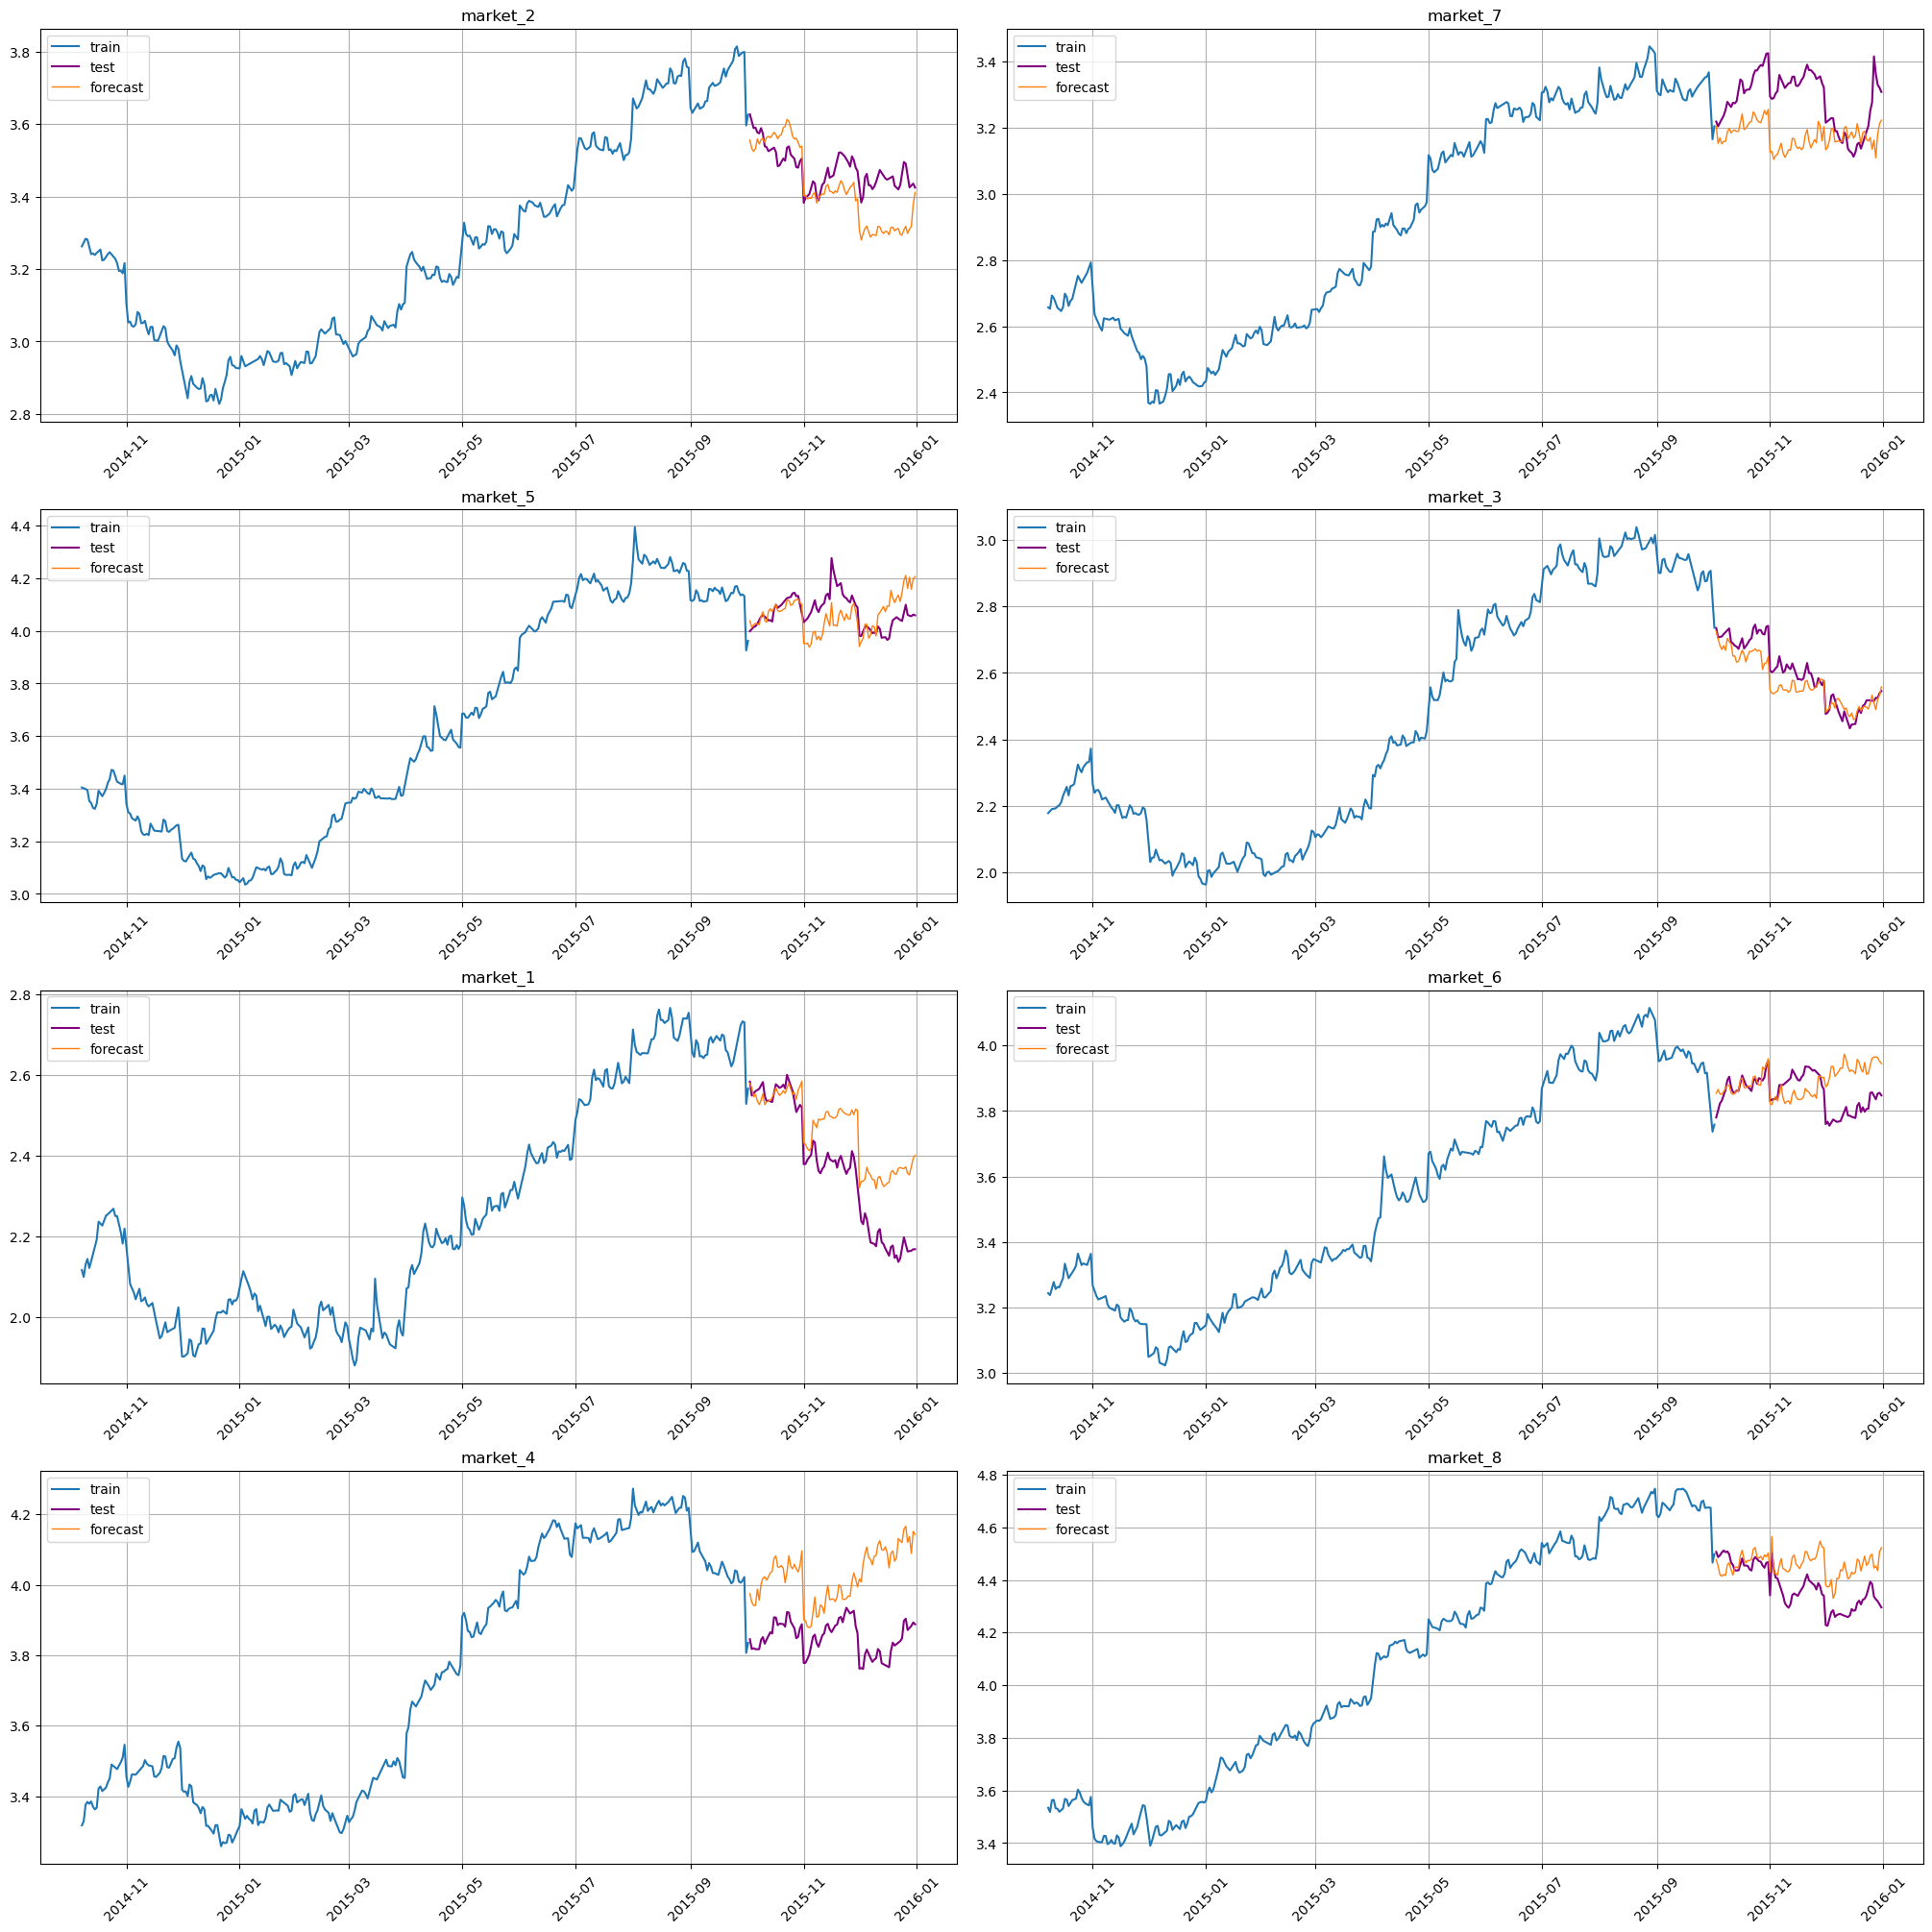

In [16]:
# визуализируем прогнозы для тестового набора, 
# здесь n_train_samples - n последних наблюдений 
# в обучающем наборе
plot_forecast(ctbst_forecast_ts, test_ts, 
              train_ts, n_train_samples=360)

In [17]:
# функция, создающая исторический набор
def hist_dataloader(internal_hist_path,
                    external_hist_path,
                    external_new_path,
                    horizon=90,
                    freq='D',
                    verbose=False):
    # загружаем исторические данные о продажах
    hist_sales = pd.read_csv(internal_hist_path, index_col=['date'], 
                             parse_dates=['date'])
    
    if verbose:
        print('загружаем исторические данные о продажах')
        bugfixed_display(hist_sales)
        
    # загружаем исторические данные о рекламной активности
    hist_advert = pd.read_csv(external_hist_path, parse_dates=['date'])
    
    if verbose:
        print('загружаем исторические данные о рекламной активности')
        bugfixed_display(hist_advert)
        
    # загружаем данные о рекламной активности в прогнозируемый период
    new_advert = pd.read_csv(external_new_path, parse_dates=['date'])
    
    if verbose:
        print('загружаем данные о рекламной активности в прогнозируемый период')
        bugfixed_display(new_advert)
         
    # берем первые 90 дней 2016 года из данных рекламной активности
    new_advert = new_advert.iloc[:horizon]
    
    if verbose:
        print('берем первые 90 дней 2016 года из данных рекламной активности')
        bugfixed_display(new_advert) 
        
    # заполним пропуски в исторических рядах продаж
    # с помощью линейной интерполяции
    for col in hist_sales.columns.tolist():
        hist_sales[col] = hist_sales[col].interpolate(method='linear')
        
    if verbose:
        print('заполним пропуски в исторических данных о продажах ' 
              'с помощью линейной интерполяции')
        bugfixed_display(hist_sales)
        
    # отбираем наблюдения с 2013 года и сбрасываем прежний индекс
    # в исторических данных о рекламной активности
    hist_sales = hist_sales[hist_sales.index >= '2013-01-01']
    hist_advert = hist_advert[hist_advert['date'] >= '2013-01-01'].reset_index(
        drop=True)
    
    if verbose:
        print('отбираем наблюдения с 2013 года и сбрасываем прежний \n'
              'индекс в исторических данных о рекламной активности')
        bugfixed_display(hist_sales)
        bugfixed_display(hist_advert)
    
    # выделим столбец с датой
    hist_sales['timestamp'] = hist_sales.index
    # сбрасываем прежний индекс
    hist_sales = hist_sales.reset_index(drop=True)
    
    if verbose:
        print('выделим столбец с датой в историческом наборе продаж '
              'и сбросим прежний индекс')
        bugfixed_display(hist_sales)
    
    # расплавляем исторический набор продаж в длинный датафрейм
    hist_sales_melt = hist_sales.melt(id_vars='timestamp', 
                                      var_name='segment', 
                                      value_name='target')
    
    if verbose:
        print('расплавляем исторический набор продаж в длинный датафрейм')
        bugfixed_display(hist_sales_melt)
        
    # переводим исторический набор продаж в формат ETNA
    hist_ts_format = TSDataset.to_dataset(hist_sales_melt)
    
    if verbose:
        print('переводим исторический набор продаж в формат ETNA')
        bugfixed_display(hist_ts_format)
        
    # конкатенируем исторические данные по рекламной активности 
    # и данные по рекламной активности в прогнозируемый период
    advert = pd.concat([hist_advert, new_advert], 
                       axis=0, ignore_index=True)
    # переименовываем date в timestamp
    advert.rename(columns={'date': 'timestamp'}, inplace=True)
    
    if verbose:
        print('конкатенируем исторические данные по рекламной активности '
              'и данные по рекламной активности в прогнозируемый период, '
              'переименовываем date в timestamp')
        bugfixed_display(advert)
      
    # расплавляем объединенные данные о рекламной 
    # активности в длинный датафрейм
    advert_melt = advert.melt(id_vars='timestamp', 
                              var_name='segment', 
                              value_name='advert')
    
    if verbose:
        print('расплавляем объединенные данные о рекламной '
              'активности в длинный датафрейм')
        bugfixed_display(advert_melt)
        
    # создаем переменную - квартал, начало и конец квартала
    advert_melt['quarter'] = advert_melt['timestamp'].dt.quarter
    # создаем переменную – начало квартала
    advert_melt['quarter_start'] = advert_melt[
        'timestamp'
    ].dt.is_quarter_start
    # создаем переменную – конец квартала
    advert_melt['quarter_end'] = advert_melt['timestamp'].dt.is_quarter_end
    # создаем переменную - название месяца
    advert_melt['month_name'] = advert_melt['timestamp'].dt.strftime('%b')
    advert_melt['month_name'] = advert_melt['month_name'].astype('category')
    
    if verbose:
        print('создаем календарные признаки в объединенных данных '
              'о рекламной активности')
        bugfixed_display(advert_melt)
    
    # переводим набор экзогенных переменных (рекламная
    # активность, календарные признаки) в формат ETNA
    df_regressors_ts_format = TSDataset.to_dataset(advert_melt)
    
    if verbose:
        print('переводим набор с экзогенными переменными (рекламная '
              'активность, календарные признаки) в формат ETNA')
        display(df_regressors_ts_format)
        
    # создаем итоговый исторический набор данных как объект TSDataset
    hist_ts = TSDataset(
        hist_ts_format, freq=freq, 
        df_exog=df_regressors_ts_format, known_future='all')
    
    if verbose:
        print('создаем итоговый исторический набор как объект TSDataset')
        display(hist_ts)
        
    return hist_ts

In [18]:
# создаем исторический набор
hist_ts = hist_dataloader(
    # путь к историческому набору эндогенных переменных
    internal_hist_path='Data/raif/sales_train.csv', 
    # путь к историческому набору экзогенных переменных
    external_hist_path='Data/raif/advert_train.csv', 
    # путь к набору экзогенных переменных
    # для прогнозируемого периода
    external_new_path='Data/raif/advert_test.csv', 
    horizon=HORIZON,
    freq='D',
    verbose=True)

загружаем исторические данные о продажах


,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
date,,,,,,,,
2008-01-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2008-01-03,NaN,1.006943,1.002595,1.006953,1.014819,NaN,1.008989,1.003241
2008-01-04,1.015188,NaN,1.043535,1.044507,1.050865,1.025508,1.037337,1.024117
2008-01-05,NaN,1.045076,NaN,1.080214,1.071665,NaN,NaN,1.028124
2008-01-06,0.995762,1.000988,1.051633,1.056388,1.047756,1.002896,1.027538,0.990433


...


,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
date,,,,,,,,
2015-12-27,2.162458,NaN,2.515498,3.871723,4.061596,NaN,3.416342,4.336864
2015-12-28,NaN,3.425255,2.525145,NaN,4.057857,3.835661,3.363259,4.326631
2015-12-29,2.164239,NaN,2.524327,3.883184,4.056121,3.852841,3.330472,4.319235
2015-12-30,2.168029,3.435747,2.538544,3.893227,4.062142,3.855567,3.321401,4.307126
2015-12-31,NaN,3.424718,2.545287,3.887936,4.059624,3.847464,3.308644,4.295573


загружаем исторические данные о рекламной активности


,date,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
0,2008-01-02,0,0,0,0,0,0,0,0
1,2008-01-03,0,0,0,0,0,0,0,0
2,2008-01-04,0,0,0,0,0,0,0,0
3,2008-01-05,0,0,0,0,0,0,0,0
4,2008-01-06,0,0,0,0,0,0,0,0


...


,date,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
2916,2015-12-27,0,0,0,0,0,0,1,0
2917,2015-12-28,0,0,0,0,0,0,0,0
2918,2015-12-29,0,0,0,0,0,0,0,0
2919,2015-12-30,0,0,0,0,0,0,0,0
2920,2015-12-31,0,0,0,0,0,0,0,0


загружаем данные о рекламной активности в прогнозируемый период


,date,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
0,2016-01-01,0,0,0,0,0,0,0,0
1,2016-01-02,0,0,0,0,0,0,0,0
2,2016-01-03,0,0,0,0,0,0,0,0
3,2016-01-04,0,0,0,0,0,0,0,0
4,2016-01-05,0,0,0,0,0,0,0,0


...


,date,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
724,2017-12-25,0,0,0,0,0,0,0,0
725,2017-12-26,0,0,0,0,0,0,0,0
726,2017-12-27,0,0,0,0,0,0,0,0
727,2017-12-28,0,0,0,0,0,0,0,0
728,2017-12-29,0,0,0,0,0,0,0,0


берем первые 90 дней 2016 года из данных рекламной активности


,date,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
0,2016-01-01,0,0,0,0,0,0,0,0
1,2016-01-02,0,0,0,0,0,0,0,0
2,2016-01-03,0,0,0,0,0,0,0,0
3,2016-01-04,0,0,0,0,0,0,0,0
4,2016-01-05,0,0,0,0,0,0,0,0


...


,date,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
85,2016-03-26,0,0,0,0,0,0,0,0
86,2016-03-27,0,0,0,0,0,0,0,0
87,2016-03-28,0,0,0,0,0,0,0,0
88,2016-03-29,0,0,0,0,0,0,0,0
89,2016-03-30,0,0,0,0,0,0,0,0


заполним пропуски в исторических данных о продажах с помощью линейной интерполяции


,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
date,,,,,,,,
2008-01-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2008-01-03,1.007594,1.006943,1.002595,1.006953,1.014819,1.012754,1.008989,1.003241
2008-01-04,1.015188,1.026009,1.043535,1.044507,1.050865,1.025508,1.037337,1.024117
2008-01-05,1.005475,1.045076,1.047584,1.080214,1.071665,1.014202,1.032438,1.028124
2008-01-06,0.995762,1.000988,1.051633,1.056388,1.047756,1.002896,1.027538,0.990433


...


,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
date,,,,,,,,
2015-12-27,2.162458,3.457937,2.515498,3.871723,4.061596,3.846346,3.416342,4.336864
2015-12-28,2.163348,3.425255,2.525145,3.877453,4.057857,3.835661,3.363259,4.326631
2015-12-29,2.164239,3.430501,2.524327,3.883184,4.056121,3.852841,3.330472,4.319235
2015-12-30,2.168029,3.435747,2.538544,3.893227,4.062142,3.855567,3.321401,4.307126
2015-12-31,2.168029,3.424718,2.545287,3.887936,4.059624,3.847464,3.308644,4.295573


отбираем наблюдения с 2013 года и сбрасываем прежний 
индекс в исторических данных о рекламной активности


,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
date,,,,,,,,
2013-01-01,1.709516,2.318572,1.721826,2.190858,2.163801,2.156222,1.672642,2.697802
2013-01-02,1.717525,2.329281,1.721189,2.195295,2.168168,2.175232,1.685756,2.704513
2013-01-03,1.723990,2.339989,1.719877,2.198767,2.182105,2.186773,1.698870,2.699439
2013-01-04,1.750044,2.350698,1.752980,2.202239,2.196042,2.227879,1.711984,2.695610
2013-01-05,1.731752,2.346491,1.759707,2.186557,2.193507,2.218857,1.701571,2.691781


...


,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
date,,,,,,,,
2015-12-27,2.162458,3.457937,2.515498,3.871723,4.061596,3.846346,3.416342,4.336864
2015-12-28,2.163348,3.425255,2.525145,3.877453,4.057857,3.835661,3.363259,4.326631
2015-12-29,2.164239,3.430501,2.524327,3.883184,4.056121,3.852841,3.330472,4.319235
2015-12-30,2.168029,3.435747,2.538544,3.893227,4.062142,3.855567,3.321401,4.307126
2015-12-31,2.168029,3.424718,2.545287,3.887936,4.059624,3.847464,3.308644,4.295573


,date,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
0,2013-01-01,0,0,0,0,0,0,0,0
1,2013-01-02,0,0,0,0,0,0,0,0
2,2013-01-03,0,0,0,0,0,0,0,0
3,2013-01-04,0,0,0,0,0,0,0,0
4,2013-01-05,0,0,0,0,0,0,0,0


...


,date,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
1090,2015-12-27,0,0,0,0,0,0,1,0
1091,2015-12-28,0,0,0,0,0,0,0,0
1092,2015-12-29,0,0,0,0,0,0,0,0
1093,2015-12-30,0,0,0,0,0,0,0,0
1094,2015-12-31,0,0,0,0,0,0,0,0


выделим столбец с датой в историческом наборе продаж и сбросим прежний индекс


,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8,timestamp
0,1.709516,2.318572,1.721826,2.190858,2.163801,2.156222,1.672642,2.697802,2013-01-01
1,1.717525,2.329281,1.721189,2.195295,2.168168,2.175232,1.685756,2.704513,2013-01-02
2,1.723990,2.339989,1.719877,2.198767,2.182105,2.186773,1.698870,2.699439,2013-01-03
3,1.750044,2.350698,1.752980,2.202239,2.196042,2.227879,1.711984,2.695610,2013-01-04
4,1.731752,2.346491,1.759707,2.186557,2.193507,2.218857,1.701571,2.691781,2013-01-05


...


,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8,timestamp
1090,2.162458,3.457937,2.515498,3.871723,4.061596,3.846346,3.416342,4.336864,2015-12-27
1091,2.163348,3.425255,2.525145,3.877453,4.057857,3.835661,3.363259,4.326631,2015-12-28
1092,2.164239,3.430501,2.524327,3.883184,4.056121,3.852841,3.330472,4.319235,2015-12-29
1093,2.168029,3.435747,2.538544,3.893227,4.062142,3.855567,3.321401,4.307126,2015-12-30
1094,2.168029,3.424718,2.545287,3.887936,4.059624,3.847464,3.308644,4.295573,2015-12-31


расплавляем исторический набор продаж в длинный датафрейм


,timestamp,segment,target
0,2013-01-01,market_1,1.709516
1,2013-01-02,market_1,1.717525
2,2013-01-03,market_1,1.723990
3,2013-01-04,market_1,1.750044
4,2013-01-05,market_1,1.731752


...


,timestamp,segment,target
8755,2015-12-27,market_8,4.336864
8756,2015-12-28,market_8,4.326631
8757,2015-12-29,market_8,4.319235
8758,2015-12-30,market_8,4.307126
8759,2015-12-31,market_8,4.295573


переводим исторический набор продаж в формат ETNA


segment,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
feature,target,target,target,target,target,target,target,target
timestamp,,,,,,,,
2013-01-01,1.709516,2.318572,1.721826,2.190858,2.163801,2.156222,1.672642,2.697802
2013-01-02,1.717525,2.329281,1.721189,2.195295,2.168168,2.175232,1.685756,2.704513
2013-01-03,1.723990,2.339989,1.719877,2.198767,2.182105,2.186773,1.698870,2.699439
2013-01-04,1.750044,2.350698,1.752980,2.202239,2.196042,2.227879,1.711984,2.695610
2013-01-05,1.731752,2.346491,1.759707,2.186557,2.193507,2.218857,1.701571,2.691781


...


segment,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
feature,target,target,target,target,target,target,target,target
timestamp,,,,,,,,
2015-12-27,2.162458,3.457937,2.515498,3.871723,4.061596,3.846346,3.416342,4.336864
2015-12-28,2.163348,3.425255,2.525145,3.877453,4.057857,3.835661,3.363259,4.326631
2015-12-29,2.164239,3.430501,2.524327,3.883184,4.056121,3.852841,3.330472,4.319235
2015-12-30,2.168029,3.435747,2.538544,3.893227,4.062142,3.855567,3.321401,4.307126
2015-12-31,2.168029,3.424718,2.545287,3.887936,4.059624,3.847464,3.308644,4.295573


конкатенируем исторические данные по рекламной активности и данные по рекламной активности в прогнозируемый период, переименовываем date в timestamp


,timestamp,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
0,2013-01-01,0,0,0,0,0,0,0,0
1,2013-01-02,0,0,0,0,0,0,0,0
2,2013-01-03,0,0,0,0,0,0,0,0
3,2013-01-04,0,0,0,0,0,0,0,0
4,2013-01-05,0,0,0,0,0,0,0,0


...


,timestamp,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
1180,2016-03-26,0,0,0,0,0,0,0,0
1181,2016-03-27,0,0,0,0,0,0,0,0
1182,2016-03-28,0,0,0,0,0,0,0,0
1183,2016-03-29,0,0,0,0,0,0,0,0
1184,2016-03-30,0,0,0,0,0,0,0,0


расплавляем объединенные данные о рекламной активности в длинный датафрейм


,timestamp,segment,advert
0,2013-01-01,market_1,0
1,2013-01-02,market_1,0
2,2013-01-03,market_1,0
3,2013-01-04,market_1,0
4,2013-01-05,market_1,0


...


,timestamp,segment,advert
9475,2016-03-26,market_8,0
9476,2016-03-27,market_8,0
9477,2016-03-28,market_8,0
9478,2016-03-29,market_8,0
9479,2016-03-30,market_8,0


создаем календарные признаки в объединенных данных о рекламной активности


,timestamp,segment,advert,quarter,quarter_start,quarter_end,month_name
0,2013-01-01,market_1,0,1,True,False,Jan
1,2013-01-02,market_1,0,1,False,False,Jan
2,2013-01-03,market_1,0,1,False,False,Jan
3,2013-01-04,market_1,0,1,False,False,Jan
4,2013-01-05,market_1,0,1,False,False,Jan


...


,timestamp,segment,advert,quarter,quarter_start,quarter_end,month_name
9475,2016-03-26,market_8,0,1,False,False,Mar
9476,2016-03-27,market_8,0,1,False,False,Mar
9477,2016-03-28,market_8,0,1,False,False,Mar
9478,2016-03-29,market_8,0,1,False,False,Mar
9479,2016-03-30,market_8,0,1,False,False,Mar


переводим набор с экзогенными переменными (рекламная активность, календарные признаки) в формат ETNA


segment    market_1                                              market_2  \
feature      advert month_name quarter quarter_end quarter_start   advert   
timestamp                                                                   
2013-01-01        0        Jan       1       False          True        0   
2013-01-02        0        Jan       1       False         False        0   
2013-01-03        0        Jan       1       False         False        0   
2013-01-04        0        Jan       1       False         False        0   
2013-01-05        0        Jan       1       False         False        0   
...             ...        ...     ...         ...           ...      ...   
2016-03-26        0        Mar       1       False         False        0   
2016-03-27        0        Mar       1       False         False        0   
2016-03-28        0        Mar       1       False         False        0   
2016-03-29        0        Mar       1       False         False        0   
2016-03-30        0        Mar       1       False         False        0   

segment                                                 market_3             \
feature    month_name quarter quarter_end quarter_start   advert month_name   
timestamp                                                                     
2013-01-01        Jan       1       False          True        0        Jan   
2013-01-02        Jan       1       False         False        0        Jan   
2013-01-03        Jan       1       False         False        0        Jan   
2013-01-04        Jan       1       False         False        0        Jan   
2013-01-05        Jan       1       False         False        0        Jan   
...               ...     ...         ...           ...      ...        ...   
2016-03-26        Mar       1       False         False        0        Mar   
2016-03-27        Mar       1       False         False        0        Mar   
2016-03-28        Mar       1       False         False        0        Mar   
2016-03-29        Mar       1       False         False        0        Mar   
2016-03-30        Mar       1       False         False        0        Mar   

segment                                      market_4                     \
feature    quarter quarter_end quarter_start   advert month_name quarter   
timestamp                                                                  
2013-01-01       1       False          True        0        Jan       1   
2013-01-02       1       False         False        0        Jan       1   
2013-01-03       1       False         False        0        Jan       1   
2013-01-04       1       False         False        0        Jan       1   
2013-01-05       1       False         False        0        Jan       1   
...            ...         ...           ...      ...        ...     ...   
2016-03-26       1       False         False        0        Mar       1   
2016-03-27       1       False         False        0        Mar       1   
2016-03-28       1       False         False        0        Mar       1   
2016-03-29       1       False         False        0        Mar       1   
2016-03-30       1       False         False        0        Mar       1   

segment                              market_5                                 \
feature    quarter_end quarter_start   advert month_name quarter quarter_end   
timestamp                                                                      
2013-01-01       False          True        0        Jan       1       False   
2013-01-02       False         False        0        Jan       1       False   
2013-01-03       False         False        0        Jan       1       False   
2013-01-04       False         False        0        Jan       1       False   
2013-01-05       False         False        0        Jan       1       False   
...                ...           ...      ...        ...     ...         ...   
2016-03-26       False       

создаем итоговый исторический набор как объект TSDataset


segment    market_1                                                         \
feature      advert month_name quarter quarter_end quarter_start    target   
timestamp                                                                    
2013-01-01        0        Jan       1       False          True  1.709516   
2013-01-02        0        Jan       1       False         False  1.717525   
2013-01-03        0        Jan       1       False         False  1.723990   
2013-01-04        0        Jan       1       False         False  1.750044   
2013-01-05        0        Jan       1       False         False  1.731752   
...             ...        ...     ...         ...           ...       ...   
2015-12-27        0        Dec       4       False         False  2.162458   
2015-12-28        0        Dec       4       False         False  2.163348   
2015-12-29        0        Dec       4       False         False  2.164239   
2015-12-30        0        Dec       4       False         False  2.168029   
2015-12-31        0        Dec       4        True         False  2.168029   

segment    market_2                                                         \
feature      advert month_name quarter quarter_end quarter_start    target   
timestamp                                                                    
2013-01-01        0        Jan       1       False          True  2.318572   
2013-01-02        0        Jan       1       False         False  2.329281   
2013-01-03        0        Jan       1       False         False  2.339989   
2013-01-04        0        Jan       1       False         False  2.350698   
2013-01-05        0        Jan       1       False         False  2.346491   
...             ...        ...     ...         ...           ...       ...   
2015-12-27        0        Dec       4       False         False  3.457937   
2015-12-28        0        Dec       4       False         False  3.425255   
2015-12-29        0        Dec       4       False         False  3.430501   
2015-12-30        0        Dec       4       False         False  3.435747   
2015-12-31        0        Dec       4        True         False  3.424718   

segment    market_3                                                         \
feature      advert month_name quarter quarter_end quarter_start    target   
timestamp                                                                    
2013-01-01        0        Jan       1       False          True  1.721826   
2013-01-02        0        Jan       1       False         False  1.721189   
2013-01-03        0        Jan       1       False         False  1.719877   
2013-01-04        0        Jan       1       False         False  1.752980   
2013-01-05        0        Jan       1       False         False  1.759707   
...             ...        ...     ...         ...           ...       ...   
2015-12-27        0        Dec       4       False         False  2.515498   
2015-12-28        0        Dec       4       False         False  2.525145   
2015-12-29        0        Dec       4       False         False  2.524327   
2015-12-30        0        Dec       4       False         False  2.538544   
2015-12-31        0        Dec       4        True         False  2.545287   

segment    market_4                                                         \
feature      advert month_name quarter quarter_end quarter_start    target   
timestamp                                                                    
2013-01-01        0        Jan       1       False          True  2.190858   
2013-01-02        0        Jan       1       False         False  2.195295   
2013-01-03        0        Jan       1       False         False  2.198767   
2013-01-04        0        Jan       1       False         False  2.202239   
2013-01-05        0        Jan       1       False         False  2.186557   
...             ...        ...     ...         ...           ...       ...   
2015-12-27        0

In [19]:
# выполняем преобразования всего исторического набора
hist_ts.fit_transform(train_preprocess)
hist_ts

segment                                                                 market_1  \
feature    LagTransform(in_column = 'target', lags = [120], out_column = None, )   
timestamp                                                                          
2013-01-01                                                NaN                      
2013-01-02                                                NaN                      
2013-01-03                                                NaN                      
2013-01-04                                                NaN                      
2013-01-05                                                NaN                      
...                                                       ...                      
2015-12-27                                           1.148758                      
2015-12-28                                           1.145271                      
2015-12-29                                           1.184206                      
2015-12-30                                           1.042882                      
2015-12-31                                           0.899683                      

segment                                                                           \
feature    LagTransform(in_column = 'target', lags = [150], out_column = None, )   
timestamp                                                                          
2013-01-01                                                NaN                      
2013-01-02                                                NaN                      
2013-01-03                                                NaN                      
2013-01-04                                                NaN                      
2013-01-05                                                NaN                      
...                                                       ...                      
2015-12-27                                           0.759236                      
2015-12-28                                           0.949322                      
2015-12-29                                           1.135929                      
2015-12-30                                           1.026451                      
2015-12-31                                           0.974291                      

segment                                                                           \
feature    LagTransform(in_column = 'target', lags = [180], out_column = None, )   
timestamp                                                                          
2013-01-01                                                NaN                      
2013-01-02                                                NaN                      
2013-01-03                                                NaN                      
2013-01-04                                                NaN                      
2013-01-05                                                NaN                      
...                                                       ...                      
2015-12-27                                           0.412574                      
2015-12-28                                           0.556073                      
2015-12-29                                           0.611244                      
2015-12-30                                           0.704461                      
2015-12-31                                           0.695468                      

segment                                                                           \
feature    LagTransform(in_column = 'target', lags = [210], out_column = None, )   
timestamp                                                                          
2013-01-01                                                NaN                      
2013-01-02                                                NaN                      
2013-01-03                                       

In [20]:
# смотрим описание исторического набора
bugfixed_full_display(hist_ts.describe())

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
market_1,2013-01-01,2015-12-31,1095,0,8,17,16,5,D
market_2,2013-01-01,2015-12-31,1095,0,8,17,16,5,D
market_3,2013-01-01,2015-12-31,1095,0,8,17,16,5,D
market_4,2013-01-01,2015-12-31,1095,0,8,17,16,5,D
market_5,2013-01-01,2015-12-31,1095,0,8,17,16,5,D
market_6,2013-01-01,2015-12-31,1095,0,8,17,16,5,D
market_7,2013-01-01,2015-12-31,1095,0,8,17,16,5,D
market_8,2013-01-01,2015-12-31,1095,0,8,17,16,5,D


In [21]:
# создаем экземпляр класса CatBoostMultiSegmentModel
ctbst_full_model = CatBoostMultiSegmentModel(
    iterations=500,
    depth=train_best_params.get('depth'))

# обучаем модель CatBoost на всем историческом наборе
ctbst_full_model.fit(hist_ts)

# формируем набор, для которого нужно получить прогнозы,
# длина набора определяется горизонтом прогнозирования,
# по сути мы формируем набор новых данных
ctbst_future_ts = hist_ts.make_future(HORIZON, train_preprocess)

# получаем прогнозы для новых данных
ctbst_forecast_ts = ctbst_full_model.forecast(
    ctbst_future_ts)

# выполняем обратные преобразования прогнозов
ctbst_forecast_ts.inverse_transform(train_preprocess)

In [22]:
# выполняем обратные преобразования для исторического набора
hist_ts.inverse_transform(train_preprocess)

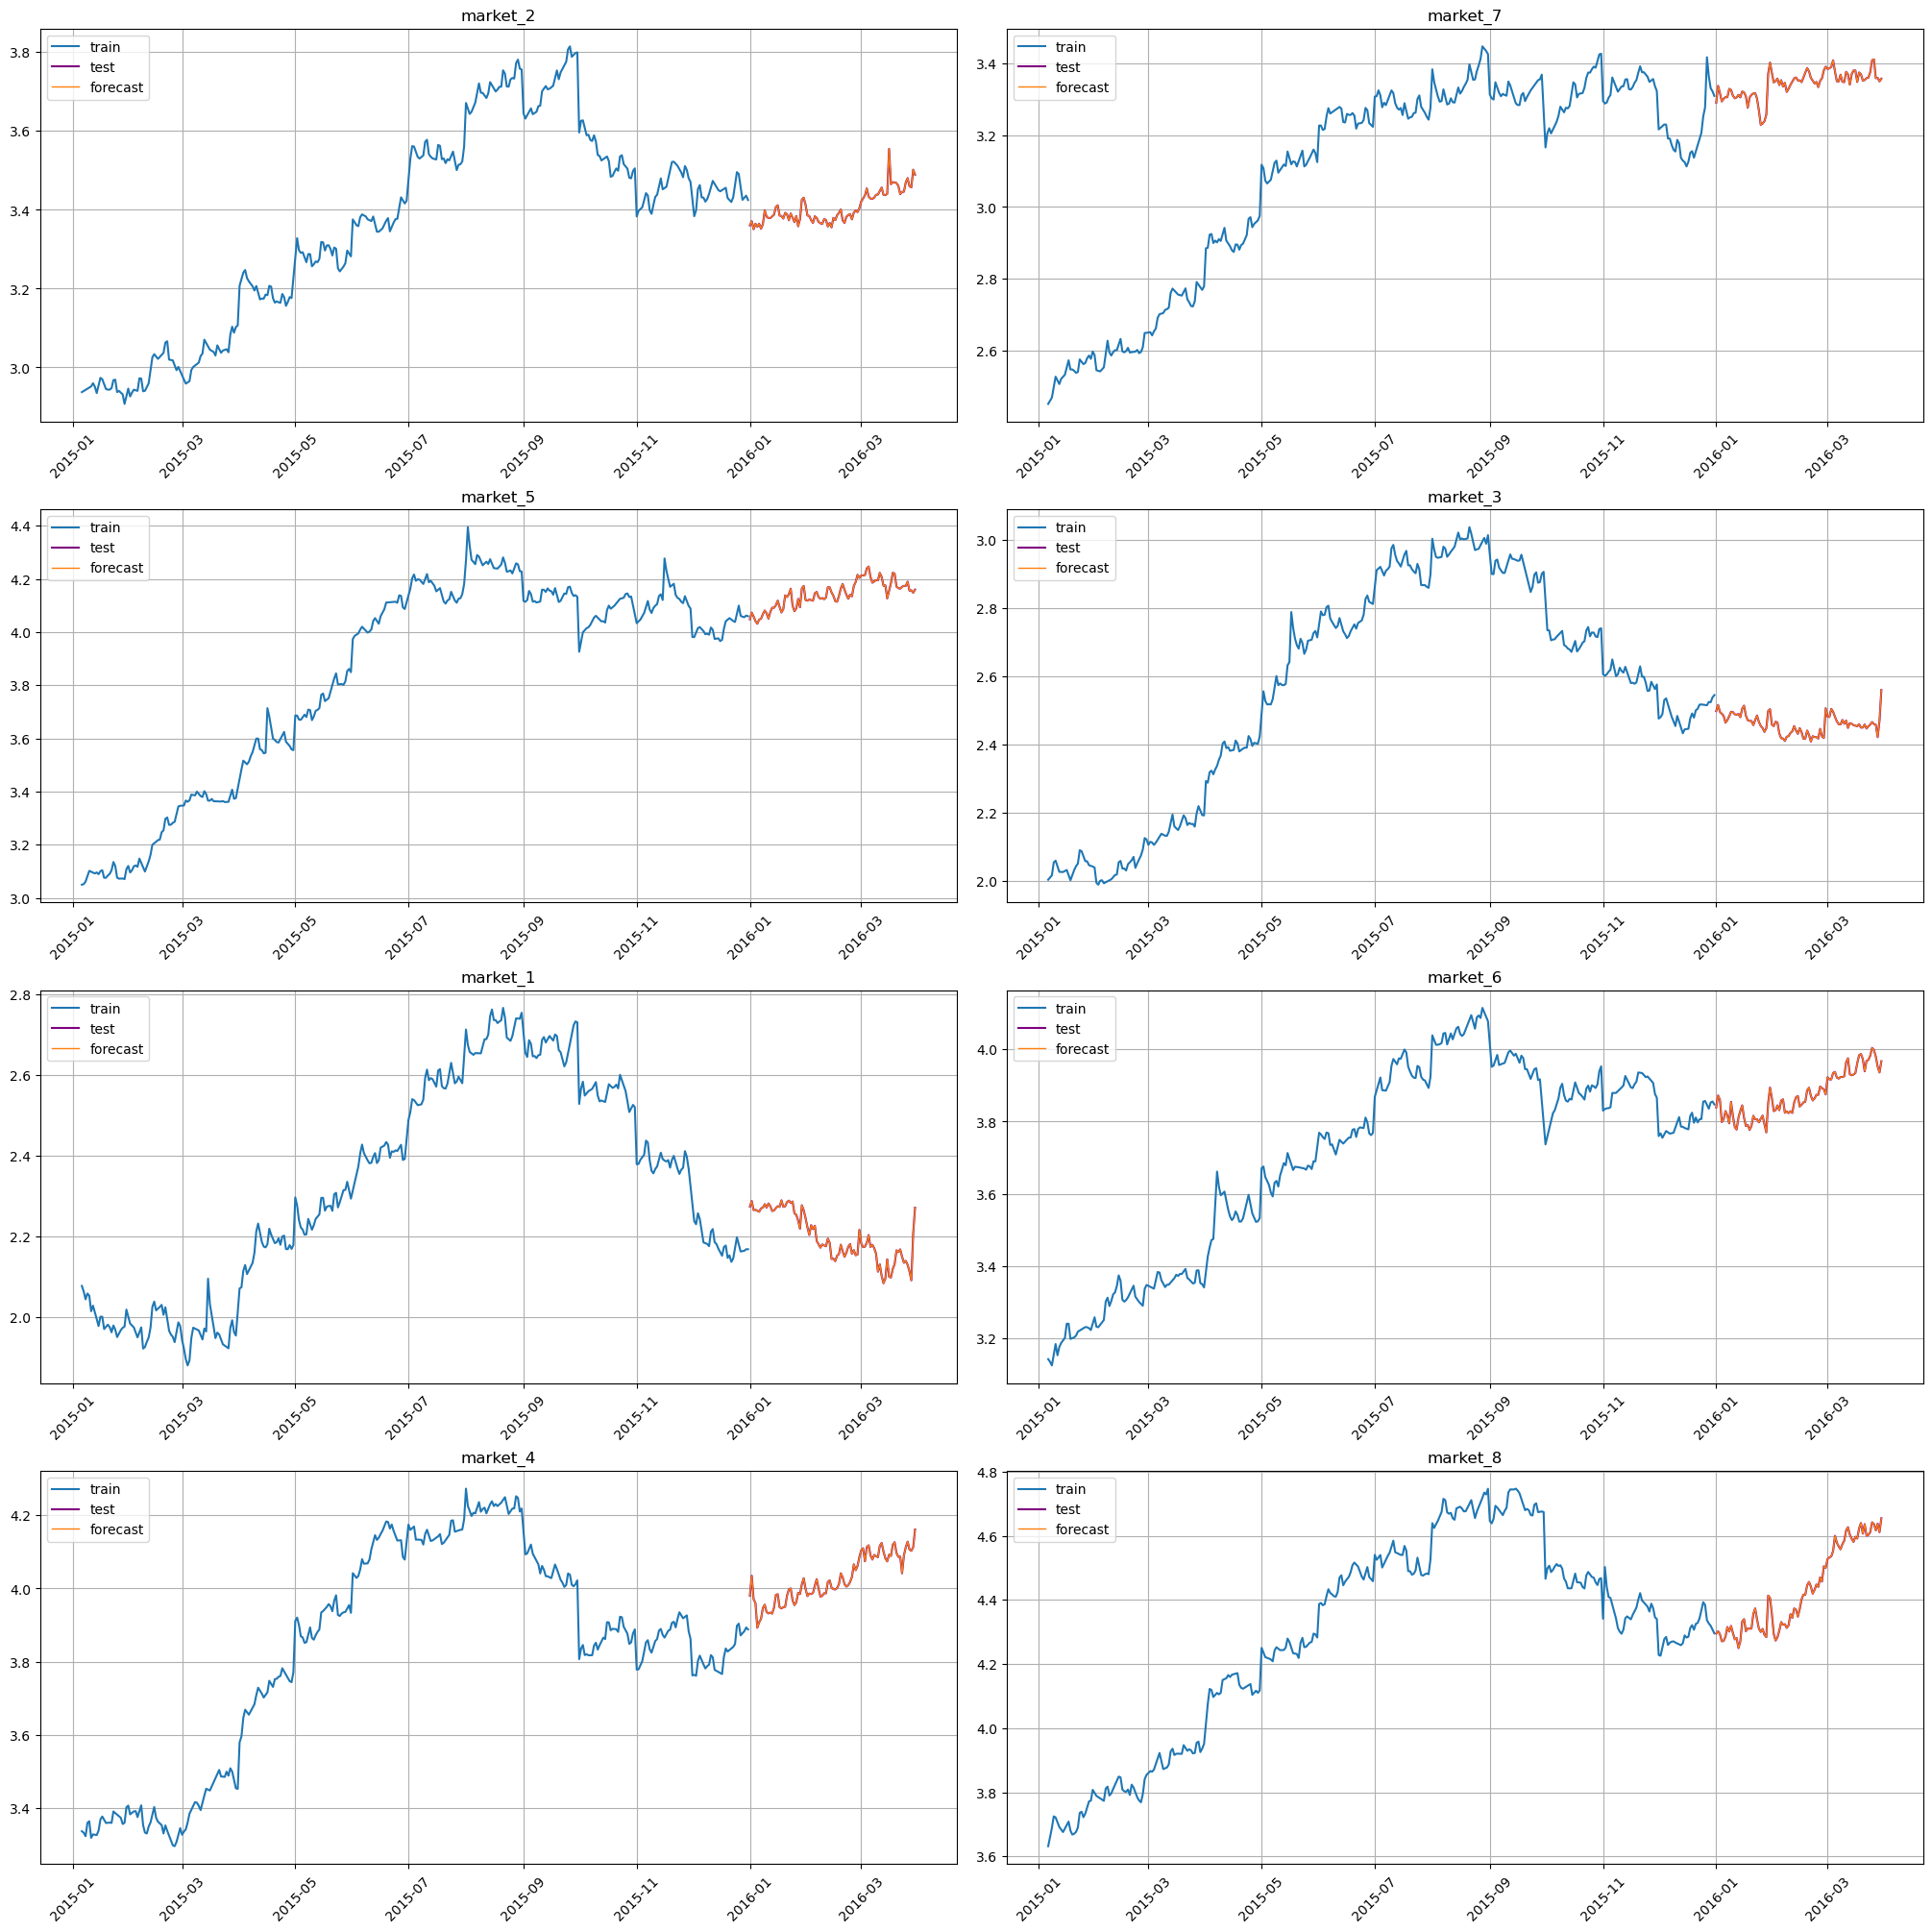

In [23]:
# визуализируем прогнозы для набора новых данных, 
# здесь n_train_samples - n последних наблюдений 
# в историческом наборе
plot_forecast(ctbst_forecast_ts, ctbst_future_ts, 
              hist_ts, n_train_samples=360)

## Оптимизация гиперпараметров без выделения отдельной тестовой выборки

In [24]:
# создаем исторический набор
hist_ts = hist_dataloader(
    # путь к историческому набору эндогенных переменных
    internal_hist_path='Data/raif/sales_train.csv', 
    # путь к историческому набору экзогенных переменных
    external_hist_path='Data/raif/advert_train.csv', 
    # путь к набору экзогенных переменных
    # для прогнозируемого периода
    external_new_path='Data/raif/advert_test.csv', 
    horizon=HORIZON,
    freq='D')
hist_ts

segment    market_1                                                         \
feature      advert month_name quarter quarter_end quarter_start    target   
timestamp                                                                    
2013-01-01        0        Jan       1       False          True  1.709516   
2013-01-02        0        Jan       1       False         False  1.717525   
2013-01-03        0        Jan       1       False         False  1.723990   
2013-01-04        0        Jan       1       False         False  1.750044   
2013-01-05        0        Jan       1       False         False  1.731752   
...             ...        ...     ...         ...           ...       ...   
2015-12-27        0        Dec       4       False         False  2.162458   
2015-12-28        0        Dec       4       False         False  2.163348   
2015-12-29        0        Dec       4       False         False  2.164239   
2015-12-30        0        Dec       4       False         False  2.168029   
2015-12-31        0        Dec       4        True         False  2.168029   

segment    market_2                                                         \
feature      advert month_name quarter quarter_end quarter_start    target   
timestamp                                                                    
2013-01-01        0        Jan       1       False          True  2.318572   
2013-01-02        0        Jan       1       False         False  2.329281   
2013-01-03        0        Jan       1       False         False  2.339989   
2013-01-04        0        Jan       1       False         False  2.350698   
2013-01-05        0        Jan       1       False         False  2.346491   
...             ...        ...     ...         ...           ...       ...   
2015-12-27        0        Dec       4       False         False  3.457937   
2015-12-28        0        Dec       4       False         False  3.425255   
2015-12-29        0        Dec       4       False         False  3.430501   
2015-12-30        0        Dec       4       False         False  3.435747   
2015-12-31        0        Dec       4        True         False  3.424718   

segment    market_3                                                         \
feature      advert month_name quarter quarter_end quarter_start    target   
timestamp                                                                    
2013-01-01        0        Jan       1       False          True  1.721826   
2013-01-02        0        Jan       1       False         False  1.721189   
2013-01-03        0        Jan       1       False         False  1.719877   
2013-01-04        0        Jan       1       False         False  1.752980   
2013-01-05        0        Jan       1       False         False  1.759707   
...             ...        ...     ...         ...           ...       ...   
2015-12-27        0        Dec       4       False         False  2.515498   
2015-12-28        0        Dec       4       False         False  2.525145   
2015-12-29        0        Dec       4       False         False  2.524327   
2015-12-30        0        Dec       4       False         False  2.538544   
2015-12-31        0        Dec       4        True         False  2.545287   

segment    market_4                                                         \
feature      advert month_name quarter quarter_end quarter_start    target   
timestamp                                                                    
2013-01-01        0        Jan       1       False          True  2.190858   
2013-01-02        0        Jan       1       False         False  2.195295   
2013-01-03        0        Jan       1       False         False  2.198767   
2013-01-04        0        Jan       1       False         False  2.202239   
2013-01-05        0        Jan       1       False         False  2.186557   
...             ...        ...     ...         ...           ...       ...   
2015-12-27        0

In [25]:
# вызов функции run_optuna, запуск оптимизации
hist_best_params = run_optuna(ts=hist_ts, 
                              horizon=HORIZON, 
                              metrics=SMAPE(),
                              n_trials=5)
hist_best_params

[I 2023-05-24 18:19:55,313] A new study created in RDB with name: no-name-2559f71c-c8a3-4235-9467-0a5574837a37



конфигурация:
Pipeline(model = CatBoostMultiSegmentModel(iterations = 500, depth = 4, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LogTransform(in_column = 'target', base = 10, inplace = True, out_column = None, ), StandardScalerTransform(in_column = ['target'], inplace = True, out_column = None, with_mean = True, with_std = True, mode = 'per-segment', ), LinearTrendTransform(in_column = 'target', poly_degree = 1, ), SegmentEncoderTransform(), LagTransform(in_column = 'target', lags = [90, 115, 140, 165, 190, 215, 240], out_column = None, ), MeanTransform(in_column = 'target', window = 104, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = None, ), DateFlagsTransform(day_number_in_week = True, day_number_in_month = True, day_number_in_year = False, week_number_in_month = False, week_number_in_year = False, month_number_in_year = True, season_number = True, year_number = False, is_weekend = True, special_d

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   48.1s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.9min remaining:    0.0s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.3min remaining:    0.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.9s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   44.0s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min remaining:    0.0s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.5min remaining:    0.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,5.74329
SMAPE_median,4.38758
SMAPE_percentile_25,3.30202
SMAPE_percentile_5,2.58486


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.5s remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,4.83878
SMAPE_median,4.21523
SMAPE_percentile_25,3.53869
SMAPE_percentile_5,2.08568


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,4.33554
SMAPE_median,4.44619
SMAPE_percentile_25,1.48372
SMAPE_percentile_5,1.02717


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.5min remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,3.62064
SMAPE_median,2.98036
SMAPE_percentile_25,1.81544
SMAPE_percentile_5,0.95241


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.1min remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,2.5333
SMAPE_median,2.02974
SMAPE_percentile_25,1.44808
SMAPE_percentile_5,0.89183


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.6min finished


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,4.21431
SMAPE_median,4.47706
SMAPE_percentile_25,3.8466
SMAPE_percentile_5,2.89941


[I 2023-05-24 18:27:31,171] Trial 0 finished with value: 4.214310305656042 and parameters: {'lag_upper_bound': 245, 'lag_step': 25, 'window_size': 104, 'depth': 4}. Best is trial 0 with value: 4.214310305656042.


метрика по сегментам:
    segment     SMAPE
0  market_1  4.974033
1  market_2  2.648456
2  market_3  5.168659
3  market_4  4.549721
4  market_5  4.006973
5  market_6  3.365471
6  market_7  4.404401
7  market_8  4.596767

конфигурация:
Pipeline(model = CatBoostMultiSegmentModel(iterations = 500, depth = 4, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LogTransform(in_column = 'target', base = 10, inplace = True, out_column = None, ), StandardScalerTransform(in_column = ['target'], inplace = True, out_column = None, with_mean = True, with_std = True, mode = 'per-segment', ), LinearTrendTransform(in_column = 'target', poly_degree = 1, ), SegmentEncoderTransform(), LagTransform(in_column = 'target', lags = [90], out_column = None, ), MeanTransform(in_column = 'target', window = 257, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = None, ), DateFlagsTransform(day_number_in_week = True, day_number_in_month = Tru

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.8s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   47.5s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.7min remaining:    0.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.9s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   43.7s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min remaining:    0.0s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.4min remaining:    0.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,4.63407
SMAPE_median,3.93915
SMAPE_percentile_25,2.9347
SMAPE_percentile_5,1.59375


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.1s remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,5.48027
SMAPE_median,3.53518
SMAPE_percentile_25,3.15786
SMAPE_percentile_5,2.15385


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   60.0s remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,5.66236
SMAPE_median,4.94857
SMAPE_percentile_25,3.42312
SMAPE_percentile_5,2.74632


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.5min remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,4.53891
SMAPE_median,4.78183
SMAPE_percentile_25,2.43465
SMAPE_percentile_5,1.74365


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.0min remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,3.4384
SMAPE_median,2.94012
SMAPE_percentile_25,2.78259
SMAPE_percentile_5,1.9023


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.5min finished


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,4.7508
SMAPE_median,5.10505
SMAPE_percentile_25,4.27606
SMAPE_percentile_5,3.01398


[I 2023-05-24 18:34:22,851] Trial 1 finished with value: 4.750801413509382 and parameters: {'lag_upper_bound': 101, 'lag_step': 15, 'window_size': 257, 'depth': 4}. Best is trial 0 with value: 4.214310305656042.


метрика по сегментам:
    segment     SMAPE
0  market_1  5.520193
1  market_2  2.537950
2  market_3  5.376787
3  market_4  4.833309
4  market_5  3.898025
5  market_6  4.402074
6  market_7  5.801198
7  market_8  5.636876

конфигурация:
Pipeline(model = CatBoostMultiSegmentModel(iterations = 500, depth = 3, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LogTransform(in_column = 'target', base = 10, inplace = True, out_column = None, ), StandardScalerTransform(in_column = ['target'], inplace = True, out_column = None, with_mean = True, with_std = True, mode = 'per-segment', ), LinearTrendTransform(in_column = 'target', poly_degree = 1, ), SegmentEncoderTransform(), LagTransform(in_column = 'target', lags = [90, 114, 138, 162, 186, 210, 234, 258], out_column = None, ), MeanTransform(in_column = 'target', window = 162, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = None, ), DateFlagsTransform(day_number_in_wee

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.9s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   47.9s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.7min remaining:    0.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.1s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   50.5s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.8min remaining:    0.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,5.96856
SMAPE_median,4.58399
SMAPE_percentile_25,3.92527
SMAPE_percentile_5,2.53889


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   36.8s remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,4.58648
SMAPE_median,3.75898
SMAPE_percentile_25,3.06292
SMAPE_percentile_5,1.9172


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,5.73698
SMAPE_median,6.39786
SMAPE_percentile_25,2.39283
SMAPE_percentile_5,1.55728


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.7min remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,4.00236
SMAPE_median,2.87717
SMAPE_percentile_25,1.60844
SMAPE_percentile_5,0.90959


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.2min remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,2.20382
SMAPE_median,1.7674
SMAPE_percentile_25,1.28749
SMAPE_percentile_5,1.14511


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.7min finished


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,4.49964
SMAPE_median,4.5282
SMAPE_percentile_25,4.09986
SMAPE_percentile_5,3.19984


[I 2023-05-24 18:41:57,451] Trial 2 finished with value: 4.499638762449214 and parameters: {'lag_upper_bound': 260, 'lag_step': 24, 'window_size': 162, 'depth': 3}. Best is trial 0 with value: 4.214310305656042.


метрика по сегментам:
    segment     SMAPE
0  market_1  5.274644
1  market_2  2.924710
2  market_3  5.823065
3  market_4  3.710783
4  market_5  4.977962
5  market_6  4.229555
6  market_7  4.558749
7  market_8  4.497642

конфигурация:
Pipeline(model = CatBoostMultiSegmentModel(iterations = 500, depth = 3, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LogTransform(in_column = 'target', base = 10, inplace = True, out_column = None, ), StandardScalerTransform(in_column = ['target'], inplace = True, out_column = None, with_mean = True, with_std = True, mode = 'per-segment', ), LinearTrendTransform(in_column = 'target', poly_degree = 1, ), SegmentEncoderTransform(), LagTransform(in_column = 'target', lags = [90, 107], out_column = None, ), MeanTransform(in_column = 'target', window = 217, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = None, ), DateFlagsTransform(day_number_in_week = True, day_number_in_month 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.0s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   46.0s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.5min remaining:    0.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.9s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   49.2s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.7min remaining:    0.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,5.83663
SMAPE_median,5.09955
SMAPE_percentile_25,3.19293
SMAPE_percentile_5,2.81881


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.1s remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,4.8426
SMAPE_median,4.32958
SMAPE_percentile_25,2.94218
SMAPE_percentile_5,1.87404


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,5.12805
SMAPE_median,4.69885
SMAPE_percentile_25,2.42471
SMAPE_percentile_5,1.48214


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.6min remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,4.44849
SMAPE_median,3.88418
SMAPE_percentile_25,2.50841
SMAPE_percentile_5,1.68436


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.2min remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,2.61615
SMAPE_median,2.51259
SMAPE_percentile_25,2.0387
SMAPE_percentile_5,1.5497


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.8min finished


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,4.57439
SMAPE_median,4.86597
SMAPE_percentile_25,4.21328
SMAPE_percentile_5,2.94229


[I 2023-05-24 18:49:19,819] Trial 3 finished with value: 4.5743873076832635 and parameters: {'lag_upper_bound': 121, 'lag_step': 17, 'window_size': 217, 'depth': 3}. Best is trial 0 with value: 4.214310305656042.


метрика по сегментам:
    segment     SMAPE
0  market_1  4.896094
1  market_2  2.347497
2  market_3  5.283915
3  market_4  4.835854
4  market_5  4.268739
5  market_6  4.046900
6  market_7  5.230902
7  market_8  5.685197

конфигурация:
Pipeline(model = CatBoostMultiSegmentModel(iterations = 500, depth = 7, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LogTransform(in_column = 'target', base = 10, inplace = True, out_column = None, ), StandardScalerTransform(in_column = ['target'], inplace = True, out_column = None, with_mean = True, with_std = True, mode = 'per-segment', ), LinearTrendTransform(in_column = 'target', poly_degree = 1, ), SegmentEncoderTransform(), LagTransform(in_column = 'target', lags = [90, 112, 134, 156, 178, 200, 222, 244, 266, 288], out_column = None, ), MeanTransform(in_column = 'target', window = 186, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = None, ), DateFlagsTransform(day_num

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.9s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   53.9s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.8min remaining:    0.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.0s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   44.9s remaining:    0.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min remaining:    0.0s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.5min remaining:    0.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,5.99993
SMAPE_median,4.3685
SMAPE_percentile_25,3.06077
SMAPE_percentile_5,2.33144


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.9s remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,4.96371
SMAPE_median,4.8582
SMAPE_percentile_25,2.92403
SMAPE_percentile_5,2.11954


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,5.41737
SMAPE_median,5.54013
SMAPE_percentile_25,2.63151
SMAPE_percentile_5,1.48395


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.6min remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,4.07926
SMAPE_median,2.56134
SMAPE_percentile_25,1.57816
SMAPE_percentile_5,1.20872


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.7min remaining:    0.0s


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,2.13882
SMAPE_median,1.80957
SMAPE_percentile_25,1.508
SMAPE_percentile_5,1.14966


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.3min finished


SMAPE_mean,▁
SMAPE_median,▁
SMAPE_percentile_25,▁
SMAPE_percentile_5,▁
SMAPE_percentile_75,▁
SMAPE_percentile_95,▁
SMAPE_std,▁
SMAPE_mean,4.51982
SMAPE_median,4.7568
SMAPE_percentile_25,4.36715
SMAPE_percentile_5,3.14904


[I 2023-05-24 18:57:10,663] Trial 4 finished with value: 4.5198179965325735 and parameters: {'lag_upper_bound': 302, 'lag_step': 22, 'window_size': 186, 'depth': 7}. Best is trial 0 with value: 4.214310305656042.


метрика по сегментам:
    segment     SMAPE
0  market_1  5.290219
1  market_2  2.533362
2  market_3  5.198737
3  market_4  4.938125
4  market_5  4.778048
5  market_6  4.392047
6  market_7  4.292452
7  market_8  4.735554


{'depth': 4, 'lag_step': 25, 'lag_upper_bound': 245, 'window_size': 104}

In [26]:
# создаем экземпляр класса LogTransform для логарифмирования 
# зависимой переменной
log = LogTransform(in_column='target')
    
# создаем экземпляр класса StandardScalerTransform
# для стандартизации зависимой переменной
scaler = StandardScalerTransform('target')
    
# создаем экземпляр класса LinearTrendTransform для прогнозирования 
# тренда, удаления тренда из даннных и добавления тренда к прогнозам
detrend = LinearTrendTransform(in_column='target')

# создаем экземпляр класса SegmentEncoderTransform для 
# кодирования меток сегментов целочисленными значениями 
# в лексикографическом порядке (LabelEncoding): сегменты
# a, b, c, d получат значения 0, 1, 2, 3
seg = SegmentEncoderTransform()
    
# создаем экземпляр класса LagTransform для генерации лагов
lag = LagTransform(
    in_column='target', 
    lags=list(range(HORIZON, 
                    hist_best_params.get('lag_upper_bound'), 
                    hist_best_params.get('lag_step')
                   )
    )
)
    
# создаем экземпляр класса MeanTransform 
# для генерации скользящих средних
mean = MeanTransform(in_column='target', 
                     window=hist_best_params.get('window_size'))
       
# создаем экземпляр класса DateFlagsTransform
# для генерации признаков на основе дат
d_flags = DateFlagsTransform(day_number_in_week=True,
                             day_number_in_month=True,
                             month_number_in_year=True,
                             season_number=True,
                             is_weekend=True, 
                             out_column='datetime')

# формируем список преобразований/признаков    
hist_preprocess = [log, scaler, detrend, seg, lag, mean, d_flags]

In [27]:
# выполняем преобразования всего исторического набора
hist_ts.fit_transform(hist_preprocess)
hist_ts

segment                                                                 market_1  \
feature    LagTransform(in_column = 'target', lags = [115], out_column = None, )   
timestamp                                                                          
2013-01-01                                                NaN                      
2013-01-02                                                NaN                      
2013-01-03                                                NaN                      
2013-01-04                                                NaN                      
2013-01-05                                                NaN                      
...                                                       ...                      
2015-12-27                                           0.867757                      
2015-12-28                                           0.984183                      
2015-12-29                                           0.956214                      
2015-12-30                                           0.865457                      
2015-12-31                                           0.865218                      

segment                                                                           \
feature    LagTransform(in_column = 'target', lags = [140], out_column = None, )   
timestamp                                                                          
2013-01-01                                                NaN                      
2013-01-02                                                NaN                      
2013-01-03                                                NaN                      
2013-01-04                                                NaN                      
2013-01-05                                                NaN                      
...                                                       ...                      
2015-12-27                                           0.950315                      
2015-12-28                                           0.997781                      
2015-12-29                                           1.045010                      
2015-12-30                                           1.044164                      
2015-12-31                                           1.073422                      

segment                                                                           \
feature    LagTransform(in_column = 'target', lags = [165], out_column = None, )   
timestamp                                                                          
2013-01-01                                                NaN                      
2013-01-02                                                NaN                      
2013-01-03                                                NaN                      
2013-01-04                                                NaN                      
2013-01-05                                                NaN                      
...                                                       ...                      
2015-12-27                                           0.795583                      
2015-12-28                                           0.766678                      
2015-12-29                                           0.879609                      
2015-12-30                                           0.888282                      
2015-12-31                                           0.763229                      

segment                                                                           \
feature    LagTransform(in_column = 'target', lags = [190], out_column = None, )   
timestamp                                                                          
2013-01-01                                                NaN                      
2013-01-02                                                NaN                      
2013-01-03                                       

In [28]:
# смотрим описание исторического набора
bugfixed_full_display(hist_ts.describe())

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
market_1,2013-01-01,2015-12-31,1095,0,8,19,18,5,D
market_2,2013-01-01,2015-12-31,1095,0,8,19,18,5,D
market_3,2013-01-01,2015-12-31,1095,0,8,19,18,5,D
market_4,2013-01-01,2015-12-31,1095,0,8,19,18,5,D
market_5,2013-01-01,2015-12-31,1095,0,8,19,18,5,D
market_6,2013-01-01,2015-12-31,1095,0,8,19,18,5,D
market_7,2013-01-01,2015-12-31,1095,0,8,19,18,5,D
market_8,2013-01-01,2015-12-31,1095,0,8,19,18,5,D


In [29]:
# создаем экземпляр класса CatBoostMultiSegmentModel
ctbst_full_model = CatBoostMultiSegmentModel(
    iterations=500,
    depth=hist_best_params.get('depth'))

# обучаем модель CatBoost на всем историческом наборе
ctbst_full_model.fit(hist_ts)

# формируем набор, для которого нужно получить прогнозы,
# длина набора определяется горизонтом прогнозирования,
# по сути мы формируем набор новых данных
ctbst_future_ts = hist_ts.make_future(HORIZON, hist_preprocess)

# получаем прогнозы для новых данных
ctbst_forecast_ts = ctbst_full_model.forecast(
    ctbst_future_ts)

# выполняем обратные преобразования прогнозов
ctbst_forecast_ts.inverse_transform(hist_preprocess)

In [30]:
# выполняем обратные преобразования для исторического набора
hist_ts.inverse_transform(hist_preprocess)

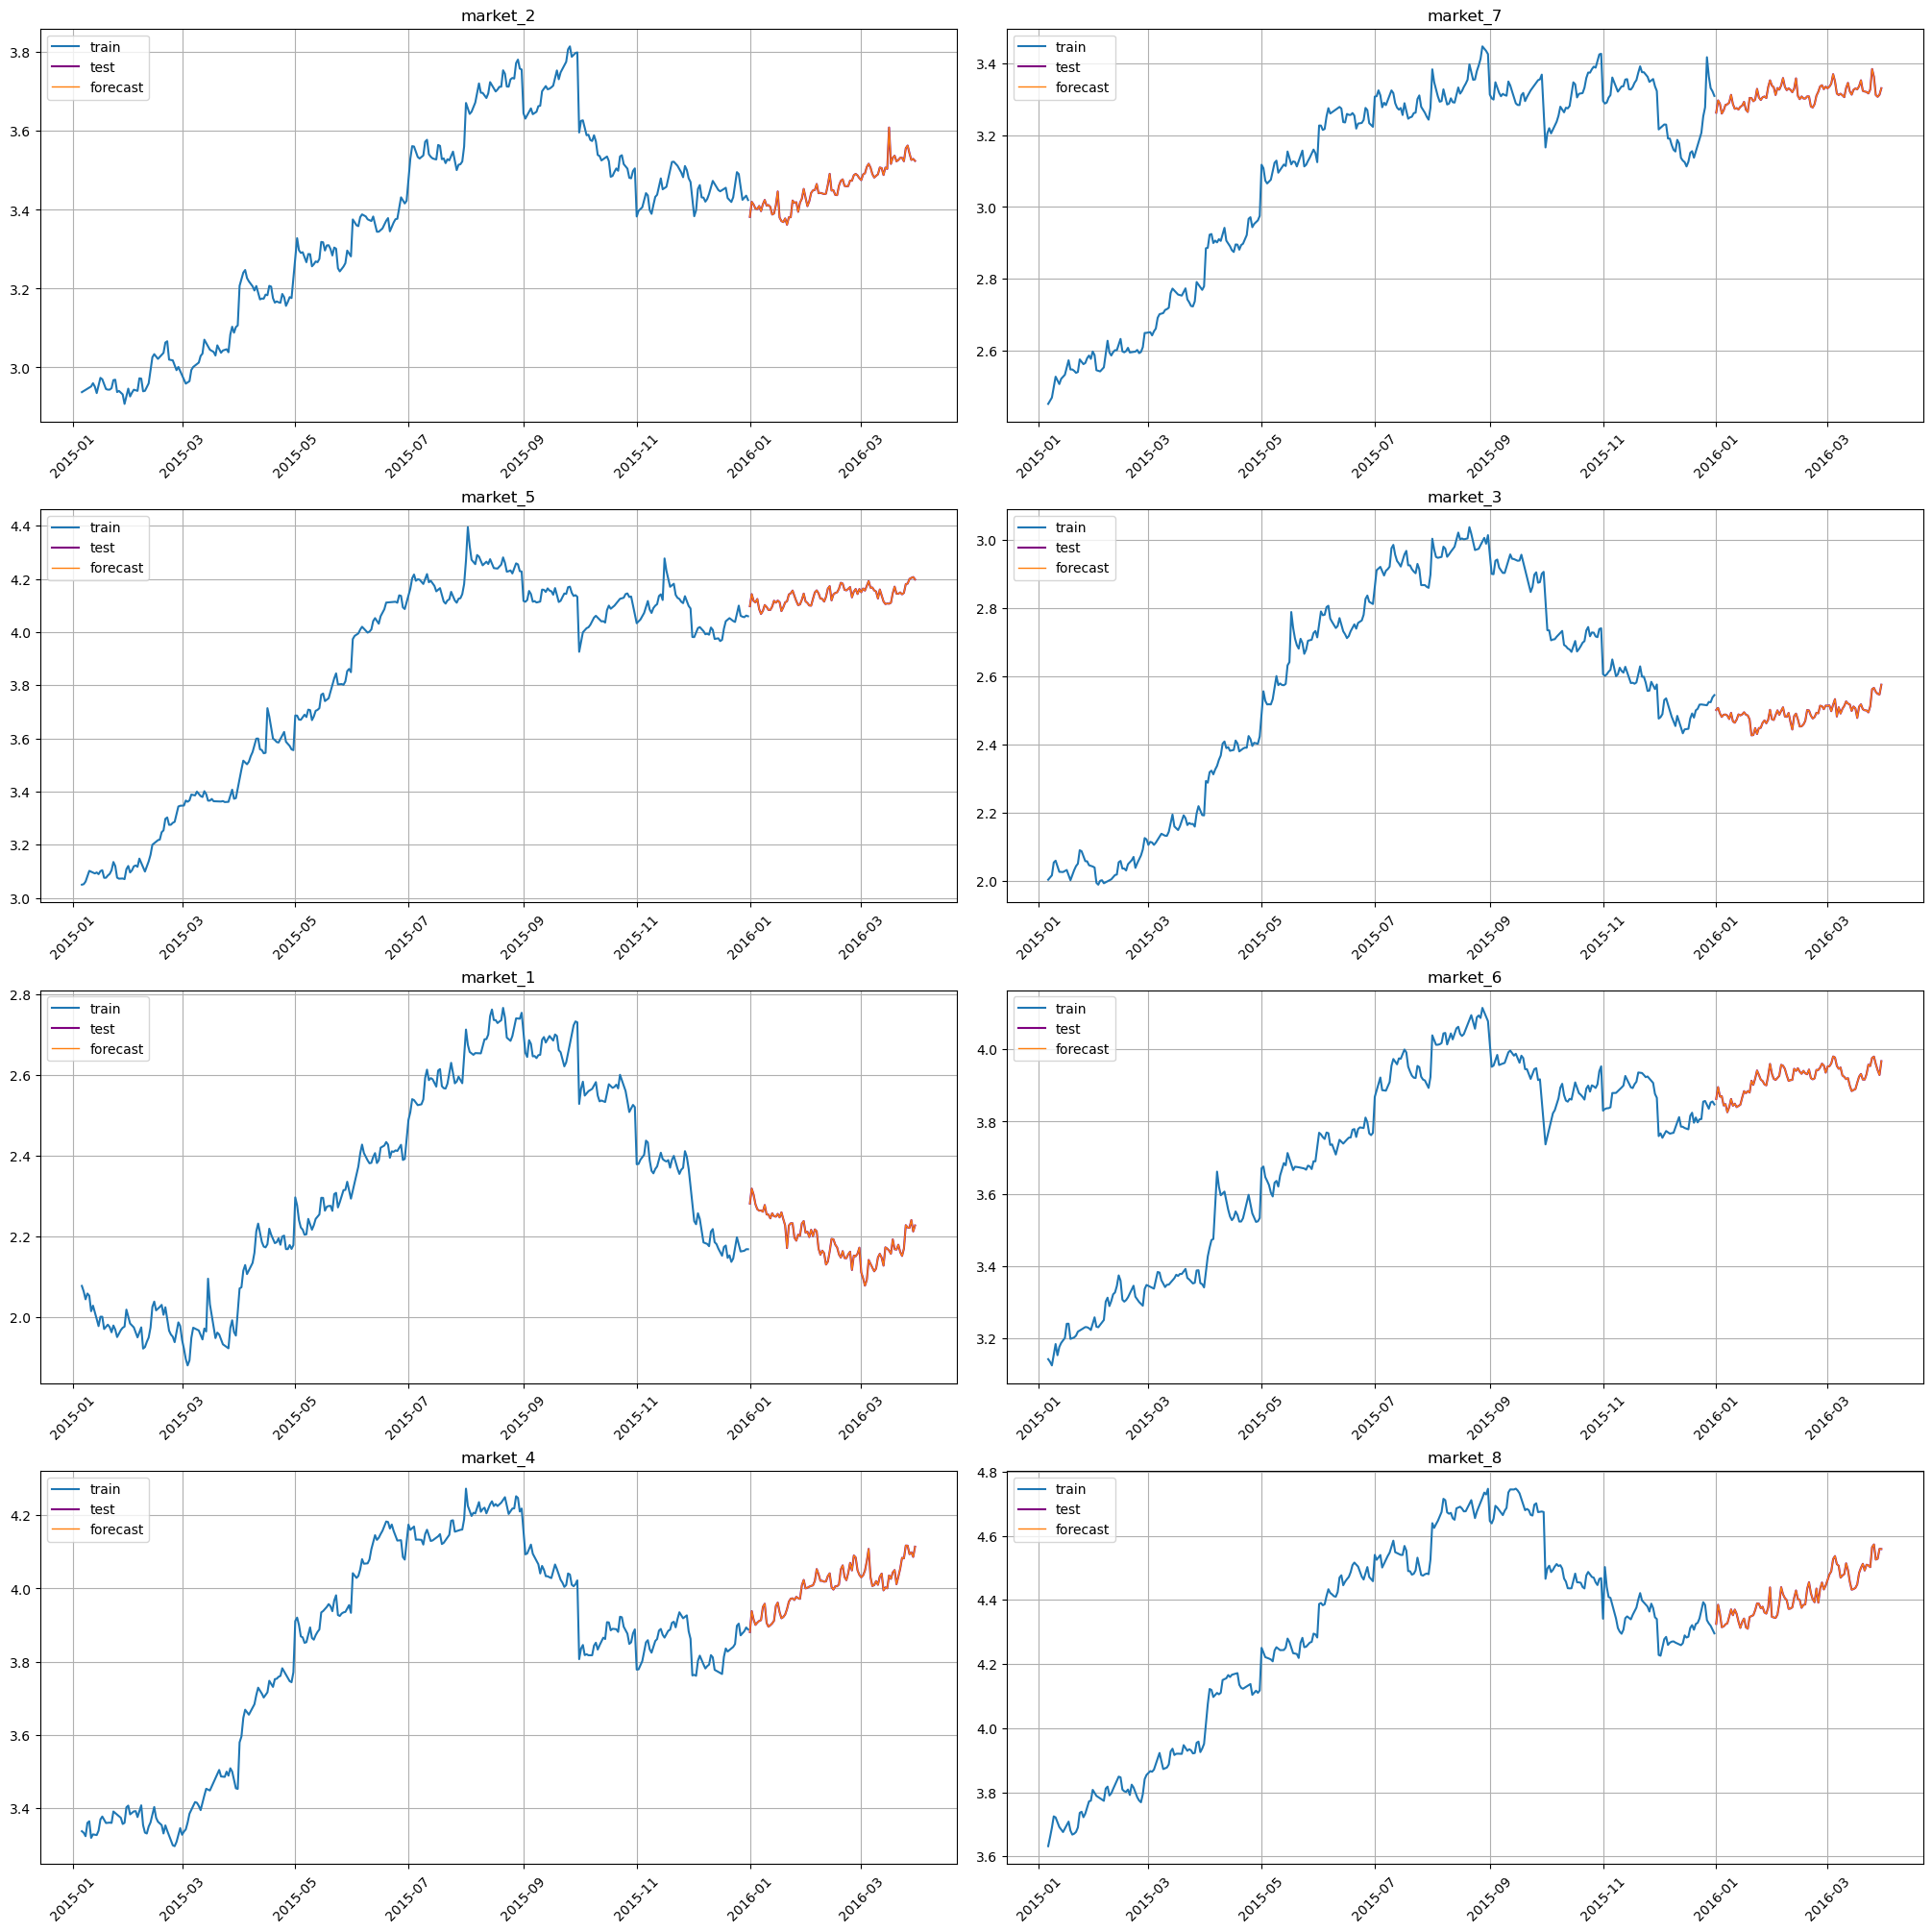

In [31]:
# визуализируем прогнозы для набора новых данных, 
# здесь n_train_samples - n последних наблюдений 
# в историческом наборе
plot_forecast(ctbst_forecast_ts, ctbst_future_ts, 
              hist_ts, n_train_samples=360)